In [2]:
import matplotlib.pyplot as plt
import numpy as np
from article import *

In [9]:
article1 = "10.1038/s41467-023-43444-3" # health
article2 = "10.1038/s41467-018-04608-8" # zou
article3 = "10.1038/s41467-023-42766-6" # cats
article4 = "10.1038/s41467-017-00516-5" # Ahn et al.
article5 = "10.1038/s41467-019-11343-1" # Jelena
article6 = "10.1038/s41467-023-40666-3" # human behavior

articles = [filename_from_DOI(doi=doi) for doi in [article1,article2,article3,article4,article5,article6]]
article_labels = [f"article {i+1}" for i in range(len(articles))]
article_labels = ["medicine","bioinformatics","ecology","chemistry","physics/EE","human behavior"]

def reset_articles():
    return [filename_from_DOI(doi=doi) for doi in [article1,article2,article3,article4,article5,article6]]

In [3]:
article10 = "10.1038/s41598-023-51013-3" # sci rep 2
article11 = "10.1038/s41598-023-43026-9" # archaeology
article12 = "10.1038/s41598-023-45072-9" # covid
article13 = "10.1038/s41467-023-43949-x" # quantum optics *
article14 = "10.1038/s41467-023-43067-8" # drug delivery
article15 = "10.1038/s41467-023-43963-z" # materials science *
articles = [filename_from_DOI(doi=doi) for doi in [article10,article11,article12,article13,article14,article15]]
article_labels = ["cardiology", "archeology","neurology","quantum optics","drug delivery","materials science"]

In [7]:
lang_dict = load_langs()['translation']
langs = lang_dict.keys()
langs_display = list(langs)
langs_display[1] = "Chinese (simp.)"
langs_display[2] = "Chinese (trad.)"

In [4]:
def get_json(fn):
    d = {}
    with open(fn, "r") as infile:
        d = json.load(infile)
    return d

def save_json(d, fn):
    with open(fn, "w") as outfile:
        json.dump(d, outfile, indent=4)

def incorrect(graded_answers):
    inc_num, inc_val = [], []
    for i in graded_answers.keys():
        if not graded_answers[i][1]:
            inc_num.append(i)
            inc_val.append(graded_answers[i][0])
    return inc_num, inc_val

In [101]:
def to_prune(folder, cutoff):
    # if *cutoff* of all languages get a specific question wrong in the quiz, prune it.
    # does not edit files; just returns which questions to ignore
    incorrect_count, to_prune = {}, []
    for l in langs:
        #print(l, article)
        try:
            answers = get_json(folder+f"/QnA_{lang_dict[l]}_answers.json")
        except:
            continue
        for q_num in answers.keys():
            if q_num not in incorrect_count.keys():
                incorrect_count[q_num] = 0
            if not answers[q_num][1]:
                incorrect_count[q_num] += 1
    for q_num in incorrect_count.keys():
        if incorrect_count[q_num]/len(langs) > cutoff:
            to_prune.append(q_num)
    return to_prune

def pruned(dict, to_prune):
    pruned = {}
    for key, val in zip(dict.keys(),dict.values()):
        if key not in to_prune:
            pruned[key] = val
    return pruned


def plot_quiz(folders, colors, barwidth=0.007, colorway=None, sortlangs=True, size=(10,3), ylim=None, plot_avg=False, legend=True, save=None, prune=1.1):
    fig, ax = plt.subplots(1,1, figsize=size)
    # x = np.linspace(0,1,len(num_langs))
    all_avgs = []
    q_length = 0 # init
    num_langs = 0
    display = []

    for count in range(len(folders)):
        folder, cs = folders[count], colors[count]
        ys = []
        for article in articles:
            fd = f"FullTexts/{article}/{folder}"
            y = []

            pruned_qs = to_prune(fd, prune)
            for l,i in zip(langs,range(len(langs))):
                # print(l, article)
                try:
                    answers = pruned(get_json(fd+f"/QnA_{lang_dict[l]}_answers.json"), pruned_qs)
                    if article == articles[0] and folder == folders[0]:
                        # account for data with some languages but not others
                        num_langs += 1
                    display.append(langs_display[i])
                except:
                    print(article, l, "not found")
                    continue
                q_length = len(answers.keys())
                incorrect_nums, incorrect_answers = incorrect(answers)
                y.append(100-int((len(incorrect_nums)/q_length)*100))
            ys.append(y)

        # print(num_langs)
        avgs = [100-sum([y[i] for y in ys])/len(articles) for i in range(num_langs)]

        # sorted_x = [a for (b,a) in sorted(zip(avgs,x), key=lambda pair: pair[0])]
        sorted_ys = [[a for (b,a) in sorted(zip(avgs,y), key=lambda pair: pair[0])] for y in ys]
        sorted_langs_display = [a for (b,a) in sorted(zip(avgs,display), key=lambda pair: pair[0])]
        sorted_avgs = [100 - a for a in sorted(avgs)]
        # sorted_ys = ys
        # sorted_langs_display = langs_display

        print(sorted_langs_display)
        print(sorted_avgs)

        if sortlangs:
            avgs_to_plot = sorted_avgs
        else:
            avgs_to_plot = [100-a for a in avgs]

        if all_avgs == []:
            all_avgs = avgs_to_plot
        else:
            all_avgs = [(a+b)/2 for a,b in zip(all_avgs, avgs_to_plot)]

        # bar_width = 0.007
        if colorway:
            colors = cs(colorway[count])
        else:
            colors = cs(np.linspace(0.4,0.65,len(ys)))

        for i in range(len(ys)):
            alpha = 1
            if len(folders) > 1:
                alpha = 0.8
            if sortlangs:
                plot_ys = sorted_ys
            else:
                plot_ys = ys
            ax.bar(np.linspace(0,1,num_langs) + barwidth*(i-len(ys)//2), plot_ys[i],
                   barwidth, color=colors[i], alpha=alpha, label=f"Article {i+1} ({article_labels[i]})") 
    if plot_avg:
        # ax.bar(x, sorted_avgs, bar_width*len(ys), color='None', alpha=1, edgecolor='black', linewidth=0.5)
        # ax.bar(x, sorted_avgs, bar_width*len(ys), edgecolor='black')
        print(all_avgs)
        plt.plot(np.linspace(0,1,num_langs), all_avgs, color="crimson", alpha=0.7, lw=2.5)

    # Set number of ticks for x-axis
    ax.set_xticks(np.linspace(0,1,num_langs))
    if ylim:
        ax.set_ylim(ylim)
    else:
        ax.set_ylim([0,100+1])
    ax.set_xlim([0-barwidth*(len(articles)//2+1),1+barwidth*(len(articles)//2)])
    # Set ticks labels for x-axis
    if sortlangs:
        labels = sorted_langs_display
    else:
        labels = langs_display
    ax.set_xticklabels(labels, rotation=70, fontsize=10)
    ax.set_ylabel('correct (%)')
    ax.tick_params(labelleft=True, labelright=True)
    ax.set_title(f"{q_length} question quiz")
    if legend:
        # ax.legend(loc="lower left", fontsize=8)
        ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left")

    if save:
        plt.savefig(save, dpi=200, bbox_inches='tight')
    plt.show()

    return all_avgs, ys


# analyze question number incorrect repetitions

def plot_q_stats(folder, color):
    fig, ax = plt.subplots(1,1, figsize=(10,3)) 
    q_length = int(folder[:2])
    x, ys = np.array([n+1 for n in range(q_length)]), [[0 for _ in range(q_length)] for _ in range(len(articles))]
    num_langs = 0
    for i in range(len(articles)):
        article = articles[i]
        print(article)
        fd = f"FullTexts/{article}/{folder}"
        for l in langs:
            try:
                answers = get_json(fd+f"/QnA_{lang_dict[l]}_answers.json")
                if article == articles[0]:
                    num_langs += 1
            except:
                print(l, "not found")
                continue
            incorrect_nums, incorrect_answers = incorrect(answers)
            incorrect_nums = [int(n)-1 for n in incorrect_nums]
            for n in incorrect_nums:
                ys[i][n] += 1

    bar_width = 0.2
    colors = color(np.linspace(0.2,0.8,len(ys)))
    for i in range(len(ys)):
        ax.bar(x + bar_width*(i-len(ys)//2), ys[i], bar_width, color=colors[i], label=article_labels[i]) 

    print([float(max(np.array(y)/num_langs)) for y in ys])

    ax.set_xticks(x)
    yticks = [n for n in range(num_langs+1) if n%2==0]
    ax.set_yticks(yticks)
    ax.set_ylim([0,max(yticks)])
    ax.set_xlim([min(x)-bar_width*(len(articles)//2+1),max(x)+bar_width*(len(articles)//2)])
    # Set ticks labels for x-axis
    ax.set_xticklabels(x, rotation=70, fontsize=10)
    ax.set_yticklabels(yticks, fontsize=10)
    ax.set_xlabel('question #')
    ax.set_ylabel('errors (all languages)')
    ax.set_title(f"{q_length} question quiz")
    ax.legend(loc="upper left", fontsize=6)
    plt.show()

['Swedish', 'English', 'German', 'Malay', 'Russian', 'Chinese (simp.)', 'Italian', 'Spanish', 'Portuguese', 'Dutch', 'Danish', 'Vietnamese', 'Chinese (trad.)', 'Korean', 'Hindi', 'Gujarati', 'Serbian', 'Swahili', 'French', 'Hebrew', 'Turkish', 'Bengali', 'Marathi', 'Arabic', 'Farsi', 'Japanese', 'Urdu', 'Telugu', 'Tamil']
[98.0, 97.33333333333333, 97.33333333333333, 97.33333333333333, 97.33333333333333, 97.0, 97.0, 97.0, 97.0, 96.66666666666667, 96.66666666666667, 96.66666666666667, 96.0, 96.0, 96.0, 96.0, 96.0, 96.0, 95.66666666666667, 95.33333333333333, 95.33333333333333, 95.0, 95.0, 95.0, 94.66666666666667, 94.33333333333333, 94.33333333333333, 94.0, 91.66666666666667]
[97.33333333333333, 97.0, 96.0, 97.33333333333333, 94.33333333333333, 95.66666666666667, 96.0, 96.0, 95.0, 94.33333333333333, 95.0, 91.66666666666667, 94.0, 96.0, 97.0, 97.0, 96.66666666666667, 98.0, 96.66666666666667, 95.33333333333333, 97.33333333333333, 96.0, 97.0, 95.33333333333333, 97.33333333333333, 95.0, 94.666

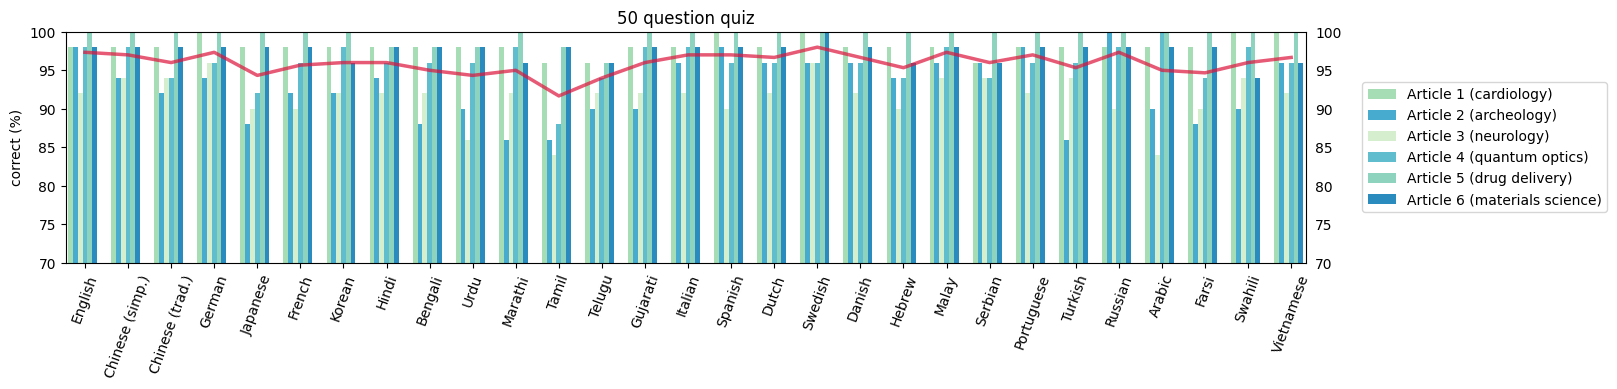

['English', 'Dutch', 'French', 'Spanish', 'Portuguese', 'Swedish', 'German', 'Arabic', 'Vietnamese', 'Hindi', 'Danish', 'Hebrew', 'Russian', 'Chinese (simp.)', 'Italian', 'Marathi', 'Gujarati', 'Farsi', 'Chinese (trad.)', 'Urdu', 'Malay', 'Turkish', 'Korean', 'Telugu', 'Japanese', 'Bengali', 'Serbian', 'Swahili', 'Tamil']
[98.0, 97.66666666666667, 97.33333333333333, 97.33333333333333, 97.33333333333333, 97.0, 96.66666666666667, 96.66666666666667, 96.66666666666667, 96.33333333333333, 96.33333333333333, 96.33333333333333, 96.33333333333333, 96.0, 96.0, 95.66666666666667, 95.66666666666667, 95.66666666666667, 95.33333333333333, 95.33333333333333, 95.33333333333333, 95.33333333333333, 95.0, 95.0, 94.66666666666667, 94.66666666666667, 94.66666666666667, 94.66666666666667, 93.66666666666667]
[98.0, 96.0, 95.33333333333333, 96.66666666666667, 94.66666666666667, 97.33333333333333, 95.0, 96.33333333333333, 94.66666666666667, 95.33333333333333, 95.66666666666667, 93.66666666666667, 95.0, 95.666

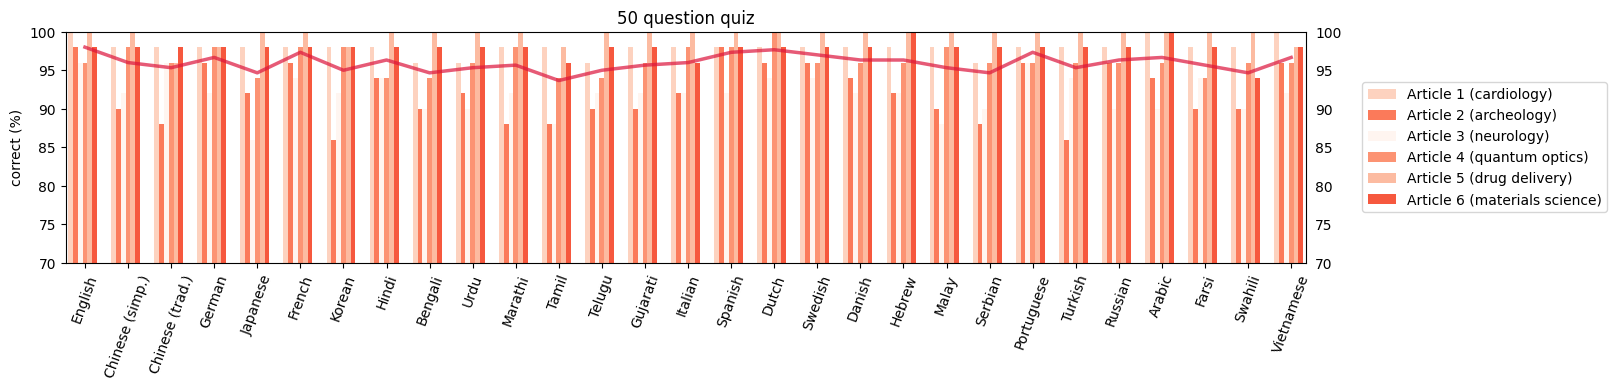

['English', 'Dutch', 'French', 'Danish', 'Serbian', 'Spanish', 'German', 'Italian', 'Russian', 'Chinese (simp.)', 'Portuguese', 'Farsi', 'Chinese (trad.)', 'Hebrew', 'Malay', 'Vietnamese', 'Korean', 'Hindi', 'Marathi', 'Swedish', 'Swahili', 'Japanese', 'Telugu', 'Turkish', 'Arabic', 'Gujarati', 'Bengali', 'Urdu', 'Tamil']
[97.66666666666667, 97.66666666666667, 97.33333333333333, 97.33333333333333, 97.33333333333333, 97.0, 96.66666666666667, 96.66666666666667, 96.66666666666667, 96.33333333333333, 96.33333333333333, 96.33333333333333, 96.0, 96.0, 96.0, 96.0, 95.66666666666667, 95.66666666666667, 95.66666666666667, 95.33333333333333, 95.33333333333333, 95.0, 95.0, 95.0, 95.0, 94.66666666666667, 93.33333333333333, 93.33333333333333, 91.33333333333333]
[97.66666666666667, 96.33333333333333, 96.0, 96.66666666666667, 95.0, 97.33333333333333, 95.66666666666667, 95.66666666666667, 93.33333333333333, 93.33333333333333, 95.66666666666667, 91.33333333333333, 95.0, 94.66666666666667, 96.6666666666

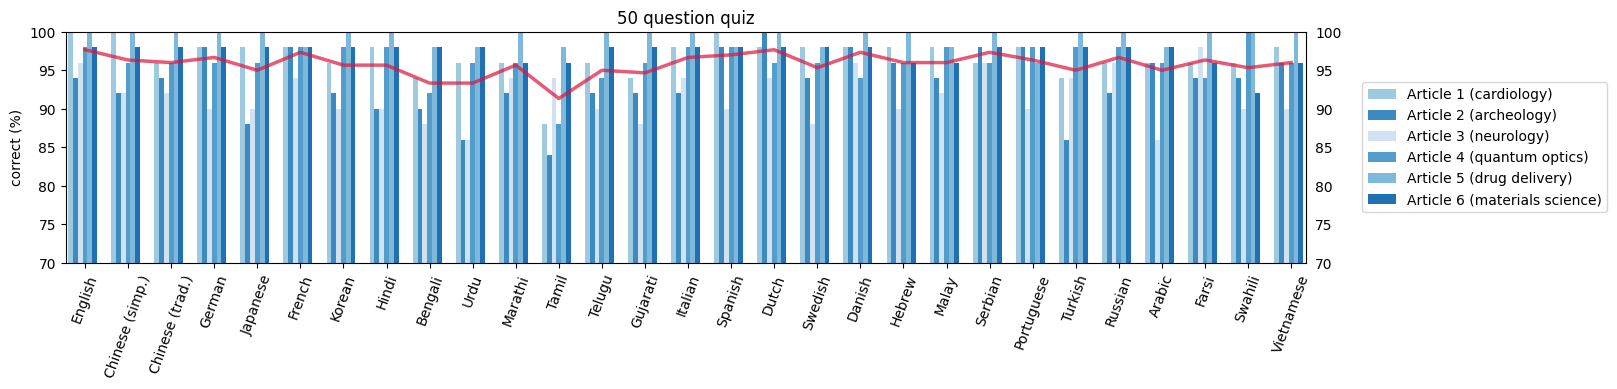

In [103]:
# 2024/12/15 new articles -- self knowledge proofed Q&A

cw = np.array([0.175,0.45,0.00,0.375,0.25,0.55])+0.2
# cw = np.linspace(0,1,len(articles))

avg1,ys1 = plot_quiz(["50q_temp1_f_gpt/GPT_translated"],
                [plt.cm.GnBu], colorway=[cw], sortlangs=False,
                barwidth=0.004, size=(16,3), ylim=[70,100],
                plot_avg=True, legend=True, save="../Figures/20241216_gpt_xml.png")

avg2,ys2 = plot_quiz(["50q_temp1_f_gpt/GPT_plaintext_translated"],
                [plt.cm.Reds], colorway=[cw-0.2], sortlangs=False,
                barwidth=0.004, size=(16,3), ylim=[70,100],
                plot_avg=True, legend=True, save="../Figures/20241216_plaintext.png")

avg3,ys3 = plot_quiz(["50q_temp1_f_gpt/google_translated"],
                [plt.cm.Blues], colorway=[cw], sortlangs=False,
                barwidth=0.004, size=(16,3), ylim=[70,100],
                plot_avg=True, legend=True, save="../Figures/20241216_google.png")

GPT with XML: 95.92
GPT with plain text: 95.95
Google Translate: 95.78


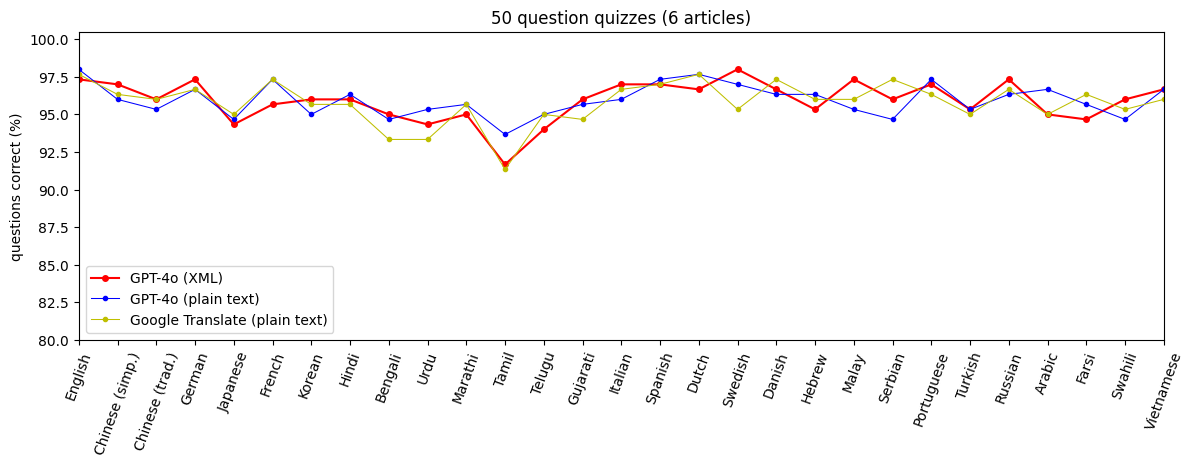

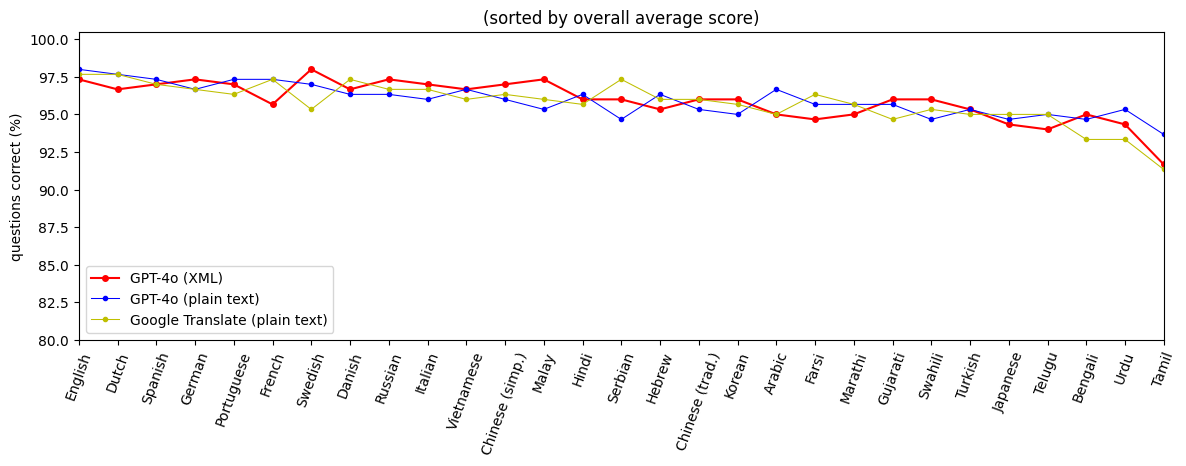

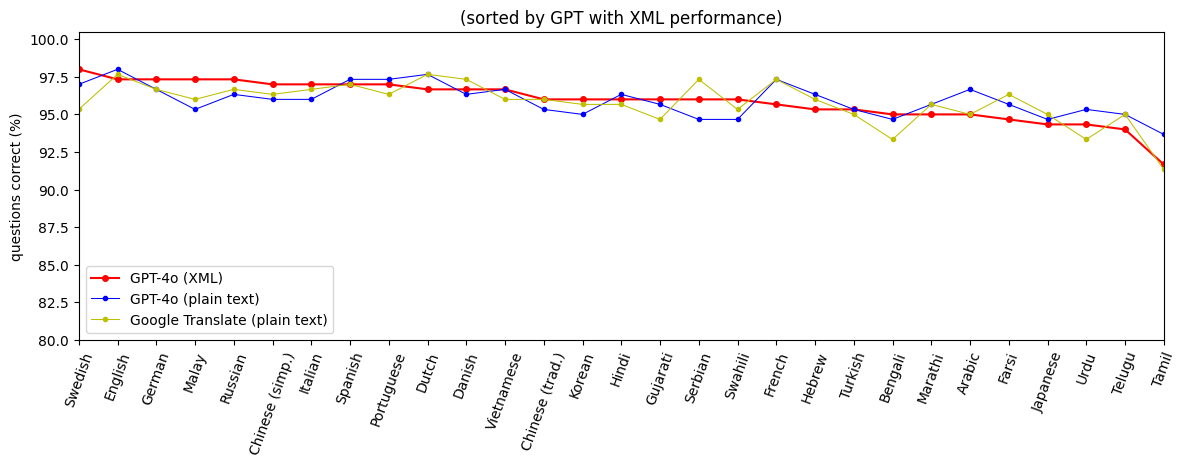

In [116]:
# 2024/12/16 - analyze the diff between quizzes performed on articles translated with GPT vs google translate.

print(f"GPT with XML: {round(sum(avg1)/len(avg1),2)}")
print(f"GPT with plain text: {round(sum(avg2)/len(avg2),2)}")
print(f"Google Translate: {round(sum(avg3)/len(avg3),2)}")

def p(a,b,c,d,t):
    fig, ax = plt.subplots(1,1, figsize=(14,4))
    x = np.arange(len(a))
    plt.plot(x,a,"ro-",linewidth=1.5,markersize=4,label="GPT-4o (XML)")
    plt.plot(x,b,"bo-",linewidth=0.75,markersize=3,label="GPT-4o (plain text)")
    plt.plot(x,c,"yo-",linewidth=0.75,markersize=3,label="Google Translate (plain text)")
    ax.set_xticks(x)
    ax.set_xticklabels(d, rotation=70, fontsize=10)
    plt.xlim([min(x),max(x)])
    plt.ylim([80,100.5])
    plt.title(t)
    plt.ylabel("questions correct (%)")
    plt.legend()
    plt.show()

def sort_to(sortby, l1, l2, l3, l4):
    c = [a for (b,a) in sorted(zip(sortby,l1), key=lambda pair: pair[0])]
    d = [a for (b,a) in sorted(zip(sortby,l2), key=lambda pair: pair[0])]
    e = [a for (b,a) in sorted(zip(sortby,l3), key=lambda pair: pair[0])]
    f = [a for (b,a) in sorted(zip(sortby,l4), key=lambda pair: pair[0])]
    return c,d,e,f

p(avg1,avg2,avg3,langs_display,"50 question quizzes (6 articles)")

# rank languages by global averages
avgs = [100-(a+b+c)/3 for a,b,c in zip(avg1,avg2,avg3)]
p(*sort_to(avgs,avg1,avg2,avg3,langs_display),"(sorted by overall average score)")

# # rank languages by absolute value of difference in results from diff translation engines.
# diffs = [(abs(a-b)+abs(a-c))/2 for a,b,c in zip(avg1,avg2,avg3)]
# p(*sort_to(diffs,avg1,avg2,avg3,langs_display),"(sorted by absolute value of deviation)")

# # rank langauges by GPT with XML performance
# diffs = [(b-(a+c)/2) for a,b,c in zip(avg1,avg2,avg3)]
# p(*sort_to(diffs,avg1,avg2,avg3,langs_display),"(sorted by comparative GPT with XML performance)")

# rank langauges by GPT with XML performance
p(*sort_to(-np.array(avg1),avg1,avg2,avg3,langs_display),"(sorted by GPT with XML performance)")


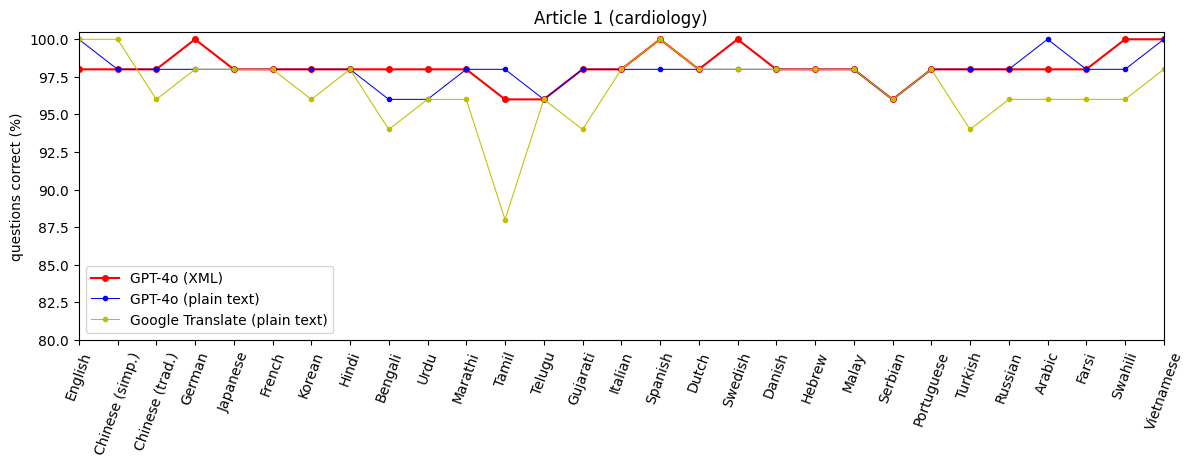

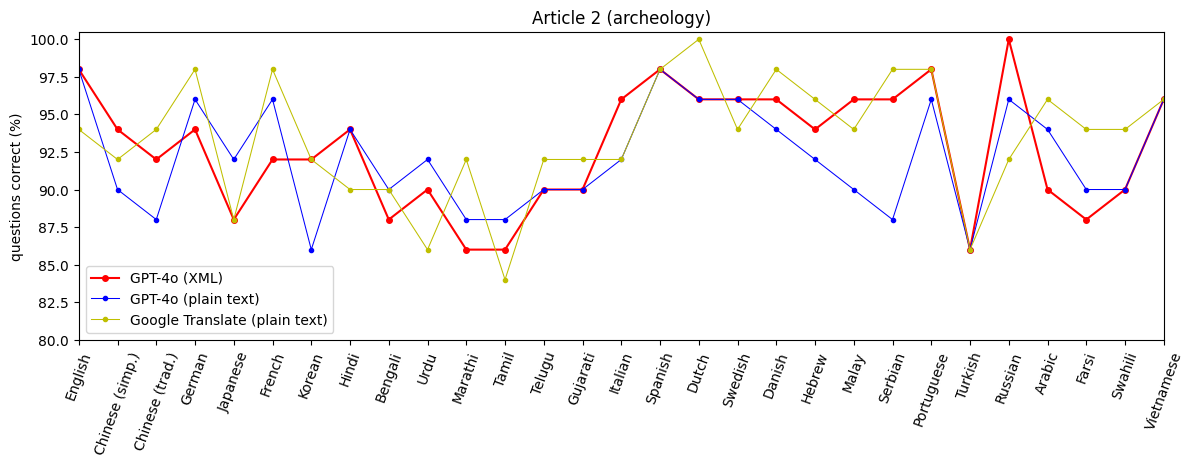

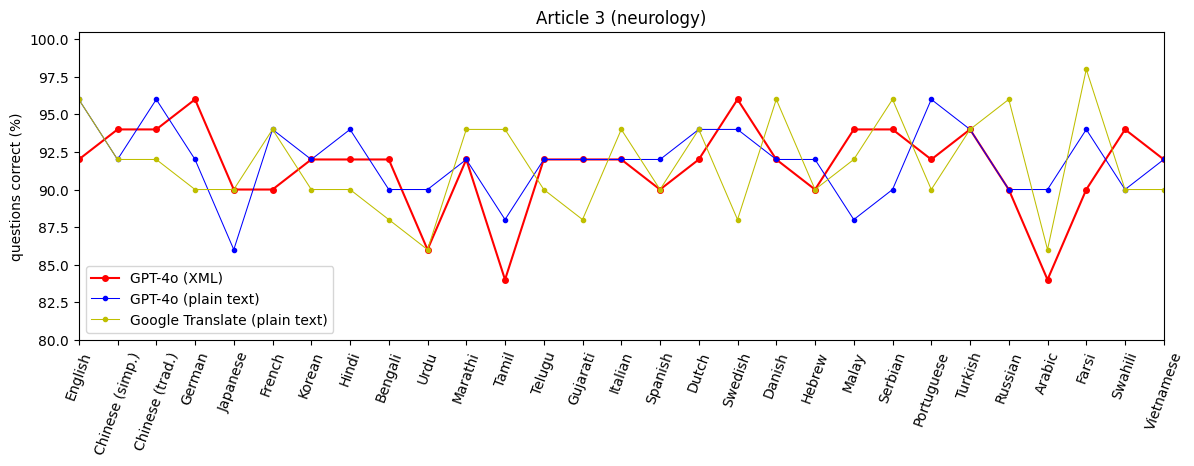

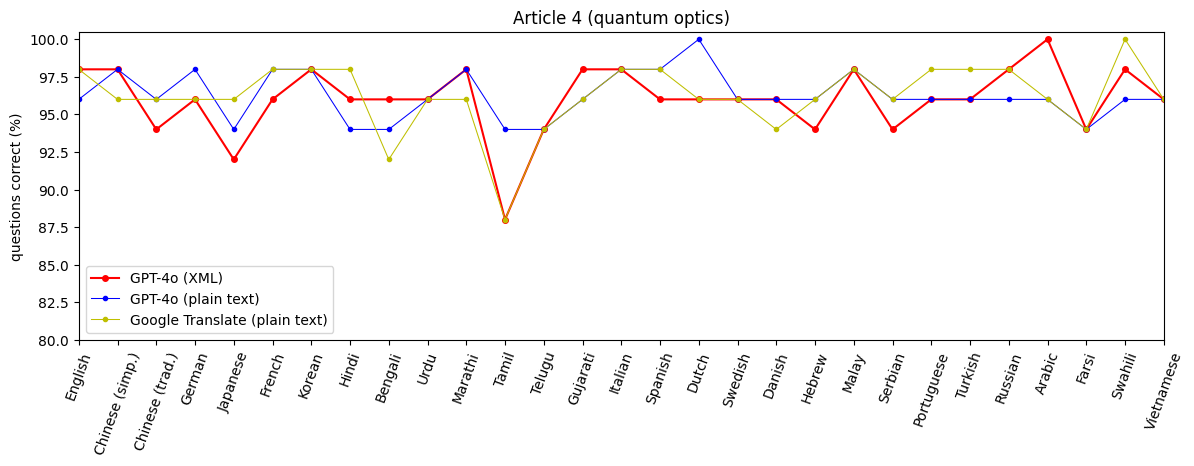

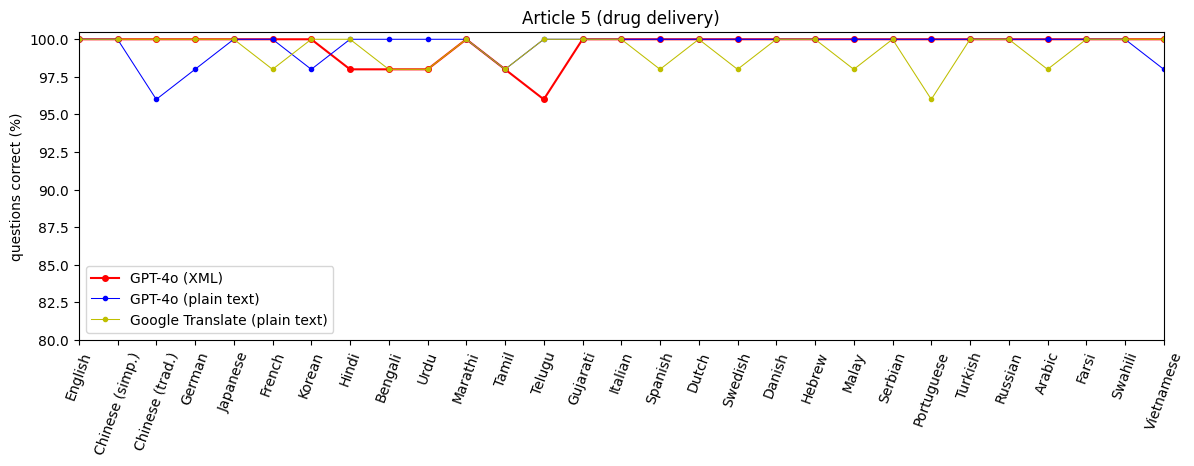

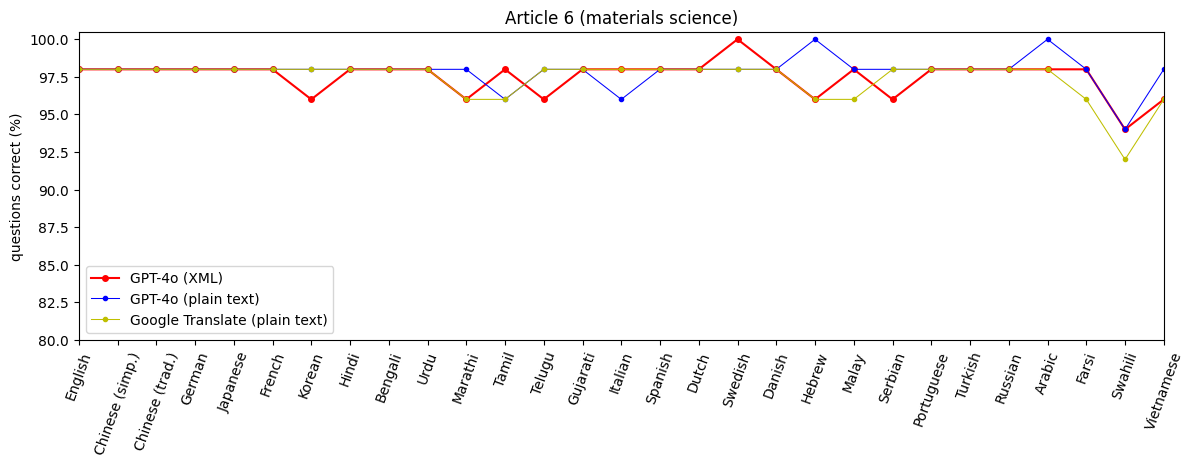

In [113]:
# 2024/12/19 - look at the articles individually

for i in range(len(ys1)):
    p(ys1[i],ys2[i],ys3[i],langs_display,f"Article {i+1} ({article_labels[i]})")

['Swedish', 'Spanish', 'Arabic', 'Farsi', 'Swahili', 'English', 'German', 'French', 'Korean', 'Bengali', 'Italian', 'Dutch', 'Hebrew', 'Serbian', 'Chinese (simp.)', 'Chinese (trad.)', 'Urdu', 'Malay', 'Vietnamese', 'Hindi', 'Turkish', 'Russian', 'Marathi', 'Portuguese', 'Danish', 'Tamil', 'Gujarati', 'Telugu', 'Japanese']
[98.33333333333333, 98.0, 98.0, 98.0, 98.0, 97.66666666666667, 97.66666666666667, 97.66666666666667, 97.66666666666667, 97.66666666666667, 97.66666666666667, 97.66666666666667, 97.66666666666667, 97.66666666666667, 97.33333333333333, 97.33333333333333, 97.33333333333333, 97.33333333333333, 97.33333333333333, 97.0, 97.0, 97.0, 96.66666666666667, 96.66666666666667, 96.33333333333333, 96.0, 95.66666666666667, 95.33333333333333, 95.0]
[97.66666666666667, 97.33333333333333, 97.33333333333333, 97.66666666666667, 95.0, 97.66666666666667, 97.66666666666667, 97.0, 97.66666666666667, 97.33333333333333, 96.66666666666667, 96.0, 95.33333333333333, 95.66666666666667, 97.6666666666

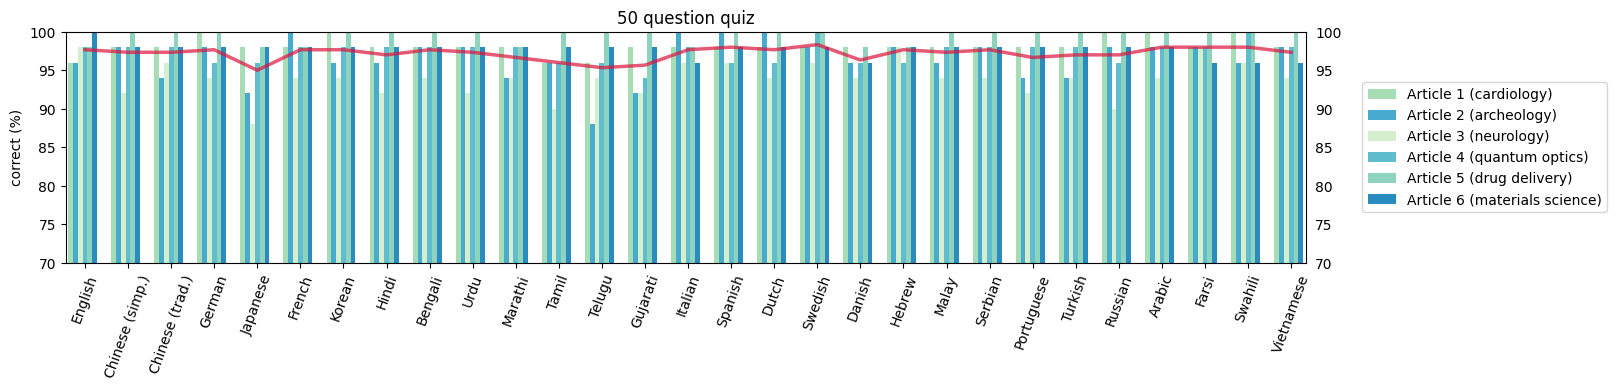

['German', 'Portuguese', 'Bengali', 'Italian', 'Spanish', 'Dutch', 'Danish', 'Chinese (simp.)', 'Chinese (trad.)', 'Korean', 'Urdu', 'Swedish', 'Malay', 'Hindi', 'Hebrew', 'Turkish', 'Russian', 'Farsi', 'English', 'Japanese', 'Marathi', 'Tamil', 'Telugu', 'Serbian', 'Vietnamese', 'Swahili', 'French', 'Arabic', 'Gujarati']
[98.66666666666667, 98.0, 97.66666666666667, 97.66666666666667, 97.66666666666667, 97.66666666666667, 97.66666666666667, 97.33333333333333, 97.33333333333333, 97.0, 97.0, 97.0, 97.0, 96.66666666666667, 96.66666666666667, 96.66666666666667, 96.66666666666667, 96.66666666666667, 96.33333333333333, 96.33333333333333, 96.33333333333333, 96.33333333333333, 96.33333333333333, 96.33333333333333, 96.33333333333333, 96.0, 95.66666666666667, 95.66666666666667, 95.33333333333333]
[96.33333333333333, 97.33333333333333, 97.33333333333333, 98.66666666666667, 96.33333333333333, 95.66666666666667, 97.0, 96.66666666666667, 97.66666666666667, 97.0, 96.33333333333333, 96.33333333333333,

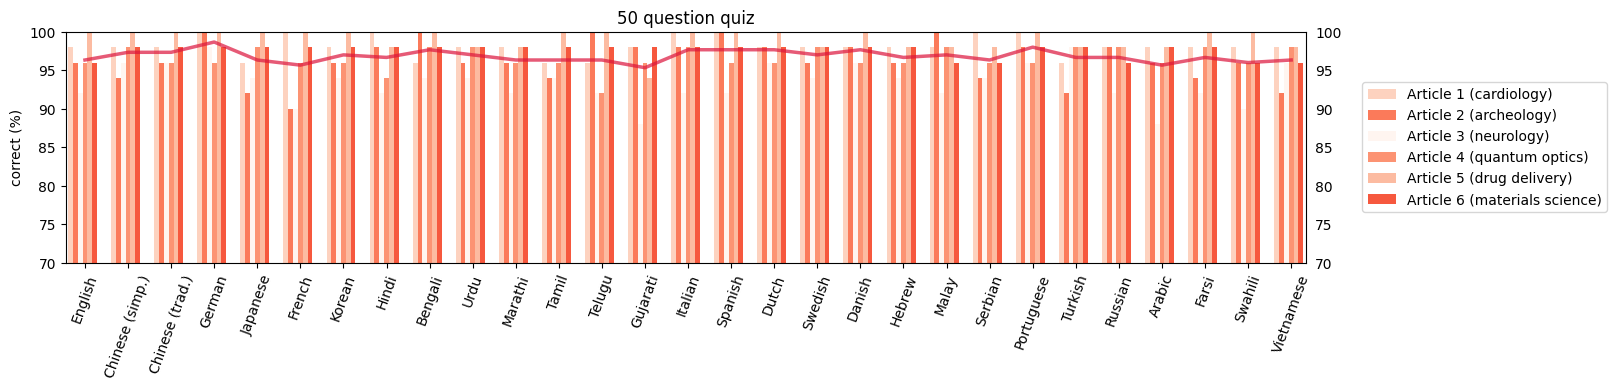

['English', 'Gujarati', 'Malay', 'Danish', 'Portuguese', 'Tamil', 'Dutch', 'Turkish', 'Korean', 'Marathi', 'Telugu', 'Spanish', 'Russian', 'Farsi', 'Swahili', 'Chinese (trad.)', 'German', 'Urdu', 'Swedish', 'Arabic', 'French', 'Hindi', 'Italian', 'Hebrew', 'Chinese (simp.)', 'Vietnamese', 'Serbian', 'Japanese', 'Bengali']
[98.33333333333333, 98.0, 98.0, 97.66666666666667, 97.66666666666667, 97.33333333333333, 97.0, 97.0, 96.66666666666667, 96.66666666666667, 96.66666666666667, 96.66666666666667, 96.66666666666667, 96.66666666666667, 96.66666666666667, 96.33333333333333, 96.33333333333333, 96.33333333333333, 96.33333333333333, 96.33333333333333, 96.0, 96.0, 96.0, 96.0, 95.66666666666667, 95.33333333333333, 95.0, 94.66666666666667, 94.66666666666667]
[98.33333333333333, 95.66666666666667, 96.33333333333333, 96.33333333333333, 94.66666666666667, 96.0, 96.66666666666667, 96.0, 94.66666666666667, 96.33333333333333, 96.66666666666667, 97.33333333333333, 96.66666666666667, 98.0, 96.0, 96.6666

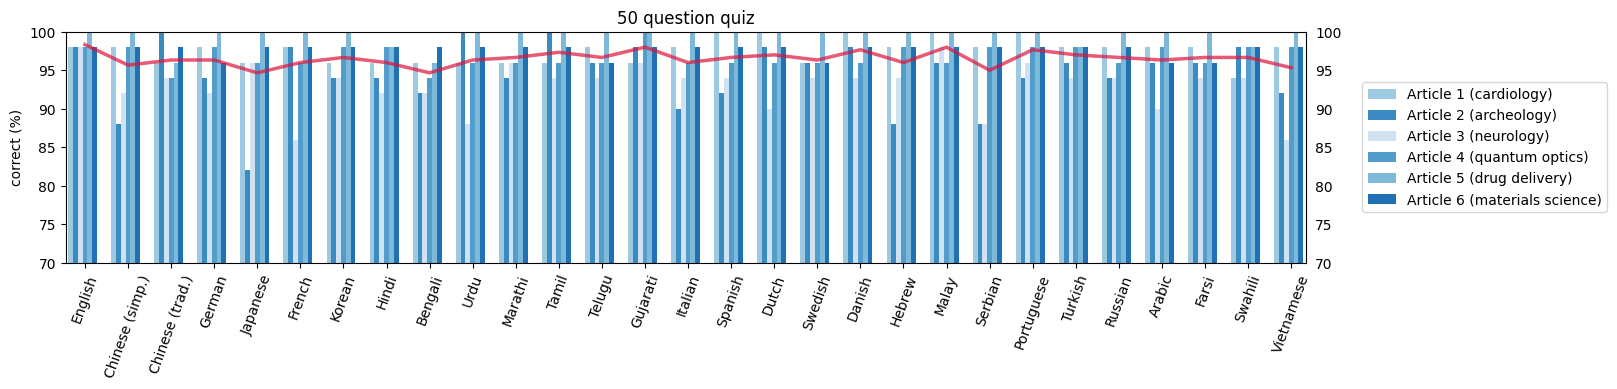

In [117]:
# 2024/12/19 - repeating the previous test but using ENGLISH Q&A questions

# 2024/12/15 new articles -- self knowledge proofed Q&A

cw = np.array([0.175,0.45,0.00,0.375,0.25,0.55])+0.2
# cw = np.linspace(0,1,len(articles))

avg1,ys1 = plot_quiz(["50q_temp1_f_gpt/GPT_translated_engq"],
                [plt.cm.GnBu], colorway=[cw], sortlangs=False,
                barwidth=0.004, size=(16,3), ylim=[70,100],
                plot_avg=True, legend=True, save="../Figures/20241216_gpt_xml.png")

avg2,ys2 = plot_quiz(["50q_temp1_f_gpt/GPT_plaintext_translated_engq"],
                [plt.cm.Reds], colorway=[cw-0.2], sortlangs=False,
                barwidth=0.004, size=(16,3), ylim=[70,100],
                plot_avg=True, legend=True, save="../Figures/20241216_plaintext.png")

avg3,ys3 = plot_quiz(["50q_temp1_f_gpt/google_translated_engq"],
                [plt.cm.Blues], colorway=[cw], sortlangs=False,
                barwidth=0.004, size=(16,3), ylim=[70,100],
                plot_avg=True, legend=True, save="../Figures/20241216_google.png")

GPT with XML: 97.2
GPT with plain text: 96.83
Google Translate: 96.51


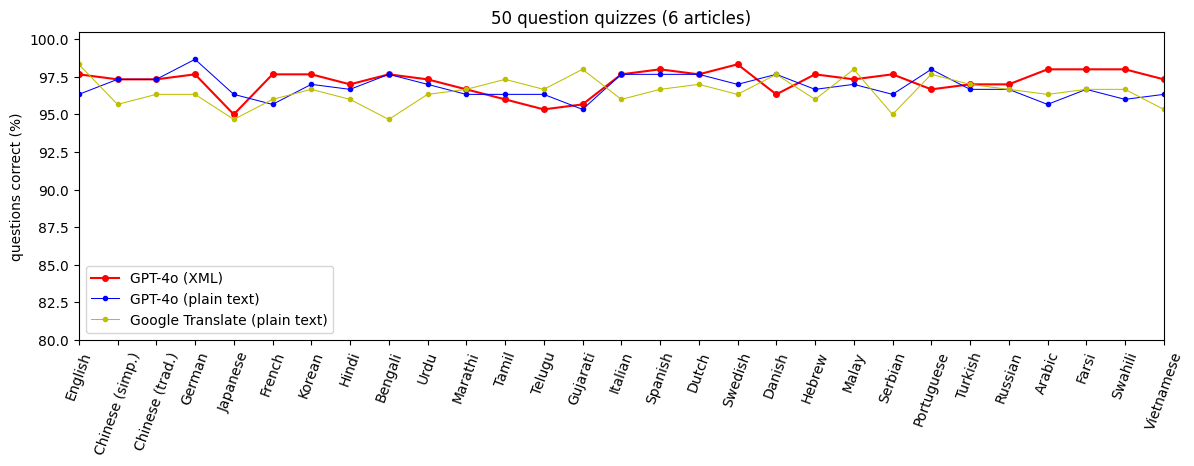

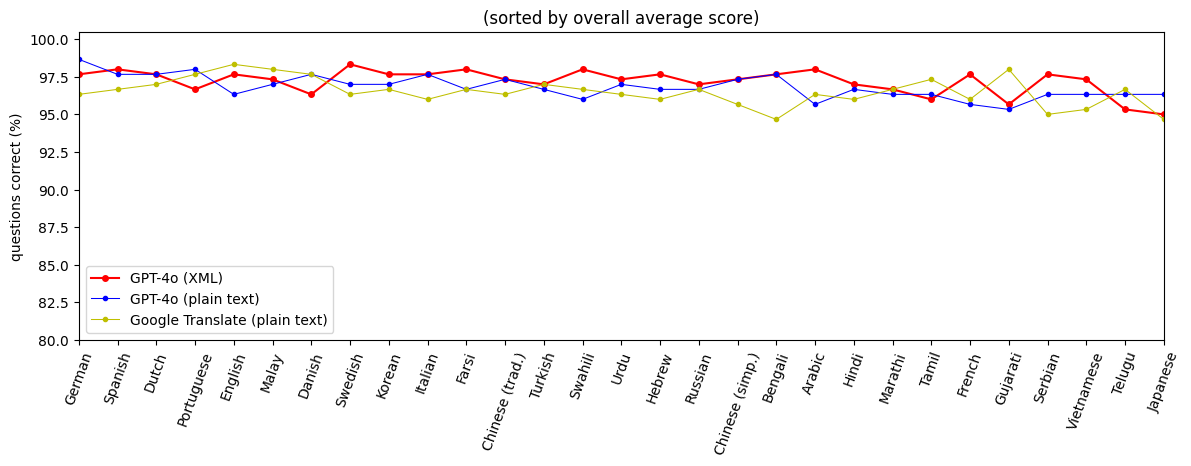

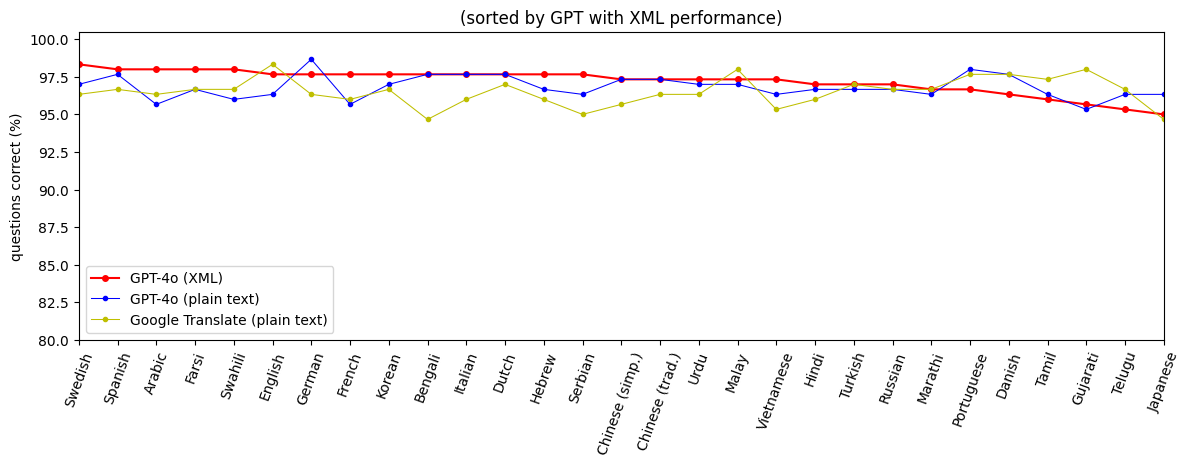

In [118]:
# 2024/12/16 - analyze the diff between quizzes performed on articles translated with GPT vs google translate.

print(f"GPT with XML: {round(sum(avg1)/len(avg1),2)}")
print(f"GPT with plain text: {round(sum(avg2)/len(avg2),2)}")
print(f"Google Translate: {round(sum(avg3)/len(avg3),2)}")

p(avg1,avg2,avg3,langs_display,"50 question quizzes (6 articles)")

# rank languages by global averages
avgs = [100-(a+b+c)/3 for a,b,c in zip(avg1,avg2,avg3)]
p(*sort_to(avgs,avg1,avg2,avg3,langs_display),"(sorted by overall average score)")

# # rank languages by absolute value of difference in results from diff translation engines.
# diffs = [(abs(a-b)+abs(a-c))/2 for a,b,c in zip(avg1,avg2,avg3)]
# p(*sort_to(diffs,avg1,avg2,avg3,langs_display),"(sorted by absolute value of deviation)")

# # rank langauges by GPT with XML performance
# diffs = [(b-(a+c)/2) for a,b,c in zip(avg1,avg2,avg3)]
# p(*sort_to(diffs,avg1,avg2,avg3,langs_display),"(sorted by comparative GPT with XML performance)")

# rank langauges by GPT with XML performance
p(*sort_to(-np.array(avg1),avg1,avg2,avg3,langs_display),"(sorted by GPT with XML performance)")


IndexError: list index out of range

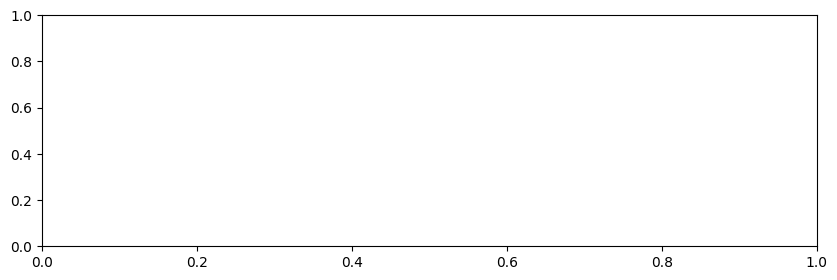

In [10]:
# 20 questions @ temp=0
# Translated questions @ temp=0
# Quiz @ temp=0,1
plot_quiz(["20q_temp0/temp0"], [plt.cm.YlGnBu], plot_avg=True)
plot_quiz(["20q_temp0/temp1"], [plt.cm.YlGnBu], plot_avg=True)
plot_quiz(["50q_temp1/temp0"], [plt.cm.BuPu], plot_avg=True)
plot_quiz(["50q_temp1/temp1"], [plt.cm.BuPu], plot_avg=True)

['English', 'German', 'French', 'Bengali', 'Italian', 'Dutch', 'Swedish', 'Hebrew', 'Malay', 'Serbian', 'Chinese (simp.)', 'Korean', 'Japanese', 'Spanish', 'Chinese (trad.)', 'Hindi', 'Danish', 'Urdu', 'Telugu', 'Marathi', 'Gujarati', 'Tamil']
[98.4, 98.4, 98.4, 98.4, 98.4, 98.4, 98.4, 98.4, 98.4, 98.4, 98.0, 98.0, 97.6, 97.6, 97.2, 97.2, 97.2, 96.4, 96.0, 95.6, 95.2, 92.8]


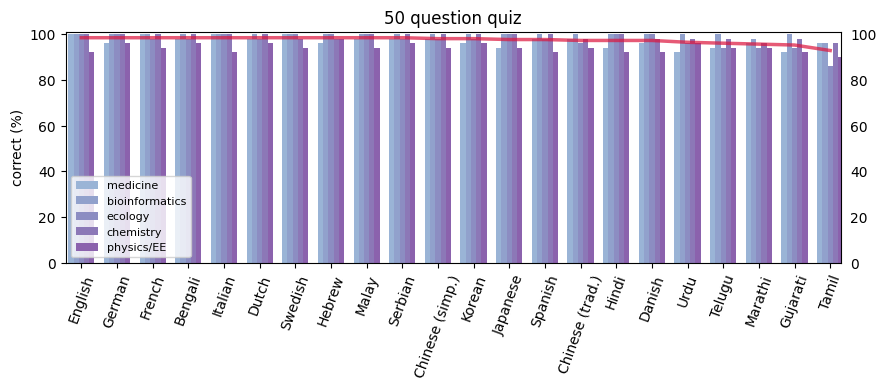

['Serbian', 'English', 'German', 'French', 'Italian', 'Dutch', 'Danish', 'Bengali', 'Spanish', 'Swedish', 'Hebrew', 'Chinese (simp.)', 'Chinese (trad.)', 'Japanese', 'Korean', 'Hindi', 'Malay', 'Urdu', 'Gujarati', 'Marathi', 'Telugu', 'Tamil']
[98.4, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 97.6, 97.6, 97.6, 97.6, 97.2, 97.2, 96.8, 96.8, 96.8, 96.8, 95.6, 95.6, 95.2, 95.2, 90.8]


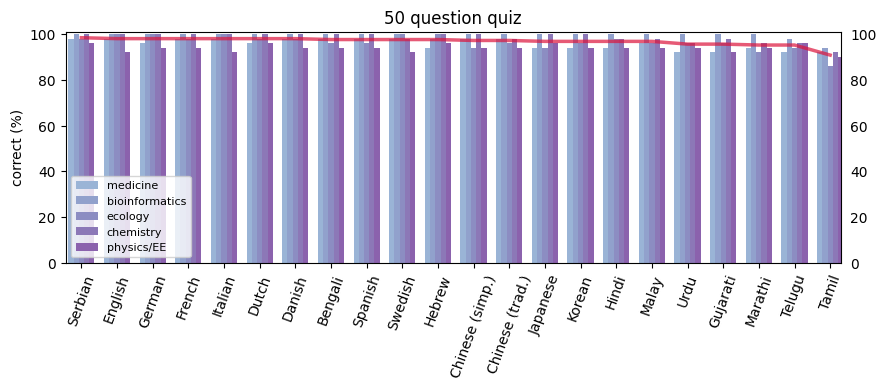

In [76]:
prune = 0.7
# plot_quiz(["20q_temp0/temp0"], [plt.cm.YlGnBu], plot_avg=True, prune=prune)
# plot_quiz(["20q_temp0/temp1"], [plt.cm.BuPu], plot_avg=True, prune=prune)
plot_quiz(["50q_temp1/temp0"], [plt.cm.BuPu], plot_avg=True, prune=prune)
plot_quiz(["50q_temp1/temp1"], [plt.cm.BuPu], plot_avg=True, prune=prune)

[0.5454545454545454, 0.0, 0.09090909090909091, 0.4090909090909091, 0.045454545454545456]


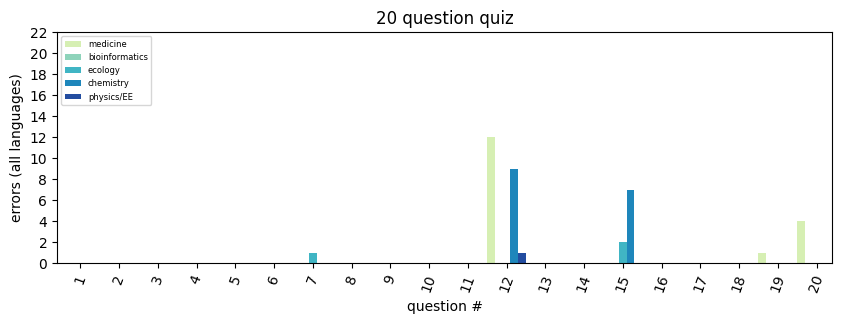

[0.5454545454545454, 0.0, 0.18181818181818182, 0.45454545454545453, 0.045454545454545456]


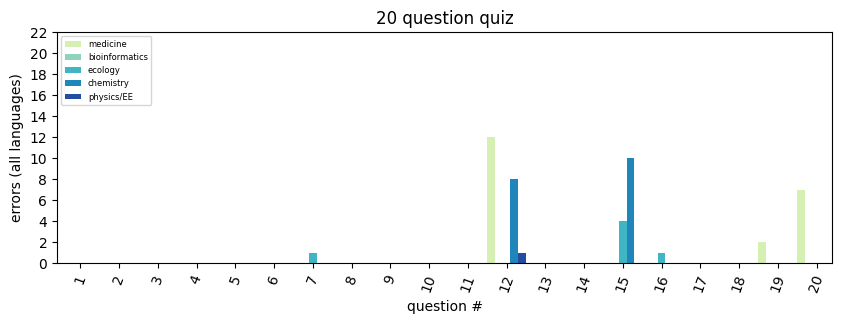

[1.0, 0.045454545454545456, 0.5, 1.0, 0.8636363636363636]


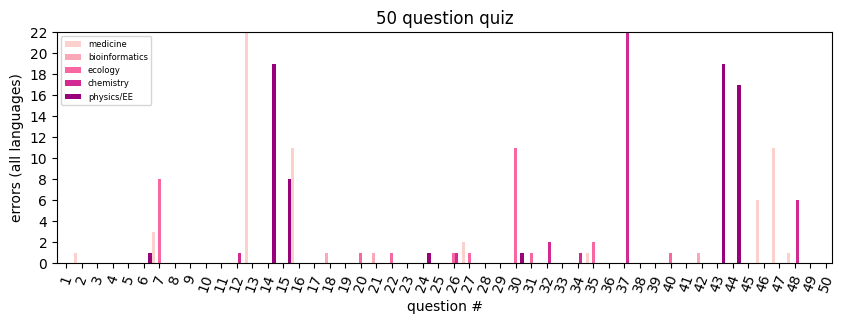

[0.9090909090909091, 0.09090909090909091, 0.4090909090909091, 1.0, 0.8636363636363636]


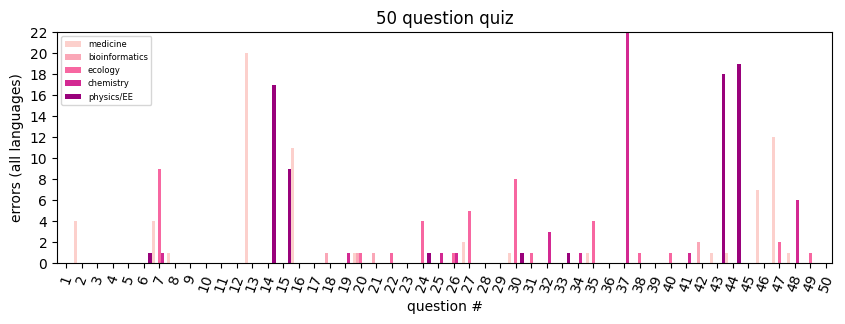

In [77]:
plot_q_stats("20q_temp0/temp0", plt.cm.YlGnBu)
plot_q_stats("20q_temp0/temp1", plt.cm.YlGnBu)
plot_q_stats("50q_temp1/temp0", plt.cm.RdPu)
plot_q_stats("50q_temp1/temp1", plt.cm.RdPu)

In [65]:
# plot_quiz(["20q_temp0/temp0","20q_temp0/temp1"], [plt.cm.Greens, plt.cm.Blues], plot_avg=True)
# plot_quiz(["50q_temp1/temp0","50q_temp1/temp1"], [plt.cm.Oranges, plt.cm.Reds], plot_avg=True)

['Chinese (trad.)', 'German', 'Bengali', 'Italian', 'Dutch', 'Swedish', 'Danish', 'Malay', 'English', 'Chinese (simp.)', 'Japanese', 'French', 'Korean', 'Hindi', 'Urdu', 'Marathi', 'Telugu', 'Gujarati', 'Spanish', 'Serbian', 'Hebrew', 'Tamil']
[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 90.0, 85.0]
['English', 'Chinese (trad.)', 'German', 'Bengali', 'Swedish', 'Danish', 'Serbian', 'Chinese (simp.)', 'Japanese', 'French', 'Korean', 'Hindi', 'Urdu', 'Marathi', 'Telugu', 'Gujarati', 'Italian', 'Spanish', 'Dutch', 'Malay', 'Hebrew', 'Tamil']
[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 90.0, 85.0]


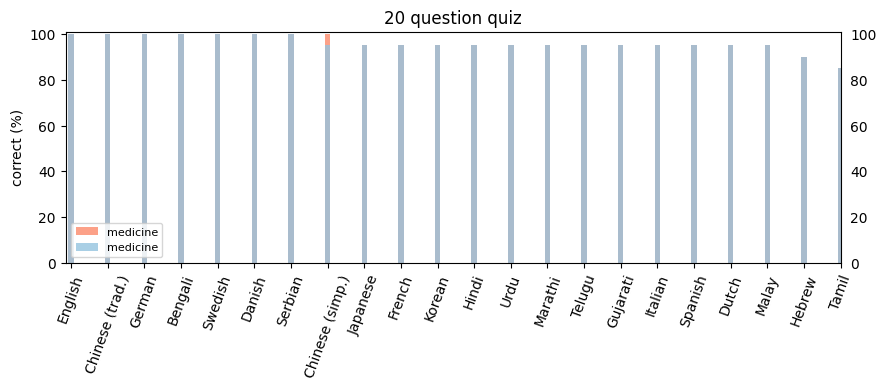

['English', 'Chinese (trad.)', 'Bengali', 'Italian', 'Dutch', 'Swedish', 'Danish', 'Chinese (simp.)', 'German', 'Japanese', 'Hindi', 'Marathi', 'Telugu', 'Gujarati', 'Malay', 'Serbian', 'French', 'Korean', 'Urdu', 'Tamil', 'Spanish', 'Hebrew']
[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0]
['German', 'Bengali', 'Spanish', 'Danish', 'Malay', 'English', 'Chinese (simp.)', 'Chinese (trad.)', 'Japanese', 'French', 'Korean', 'Hindi', 'Urdu', 'Marathi', 'Gujarati', 'Italian', 'Dutch', 'Swedish', 'Serbian', 'Telugu', 'Hebrew', 'Tamil']
[100.0, 100.0, 100.0, 100.0, 100.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 90.0, 90.0, 85.0]


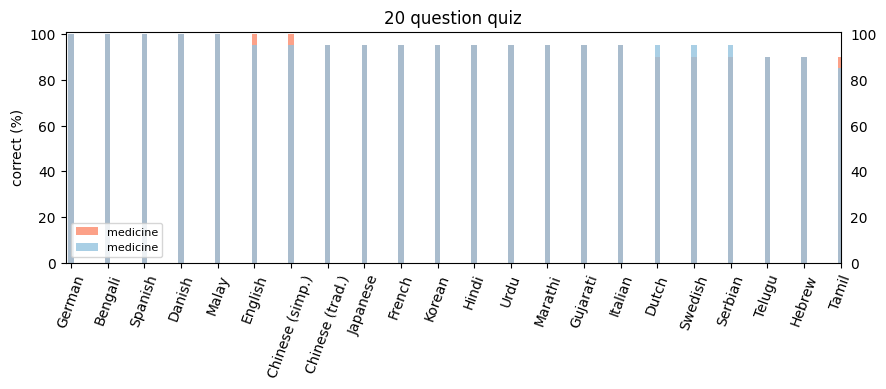

['English', 'French', 'Italian', 'Swedish', 'Chinese (simp.)', 'Chinese (trad.)', 'Bengali', 'Spanish', 'Dutch', 'Malay', 'Serbian', 'German', 'Korean', 'Marathi', 'Tamil', 'Danish', 'Hebrew', 'Japanese', 'Hindi', 'Telugu', 'Urdu', 'Gujarati']
[98.0, 98.0, 98.0, 98.0, 96.0, 96.0, 96.0, 96.0, 96.0, 96.0, 96.0, 94.0, 94.0, 94.0, 94.0, 94.0, 94.0, 92.0, 92.0, 92.0, 90.0, 90.0]
['French', 'Italian', 'Swedish', 'Serbian', 'Chinese (simp.)', 'Chinese (trad.)', 'Bengali', 'Spanish', 'Dutch', 'Danish', 'English', 'Korean', 'Hindi', 'Marathi', 'Tamil', 'Hebrew', 'Malay', 'German', 'Japanese', 'Telugu', 'Urdu', 'Gujarati']
[98.0, 98.0, 98.0, 98.0, 96.0, 96.0, 96.0, 96.0, 96.0, 96.0, 94.0, 94.0, 94.0, 94.0, 94.0, 94.0, 94.0, 92.0, 92.0, 92.0, 90.0, 90.0]


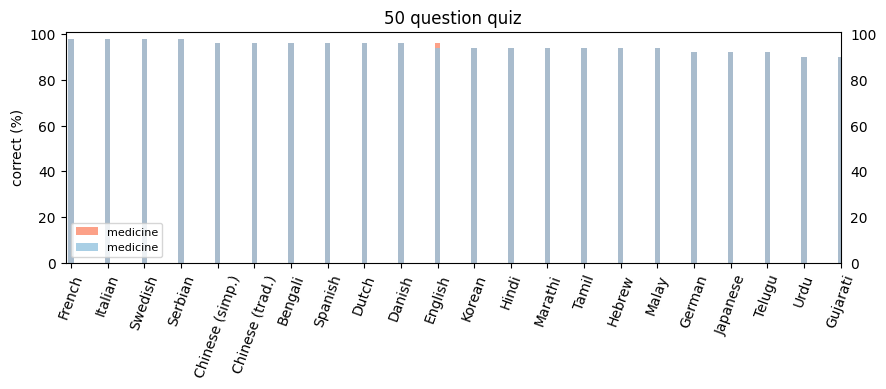

['Bengali', 'Spanish', 'English', 'Chinese (simp.)', 'Chinese (trad.)', 'French', 'Italian', 'Swedish', 'Danish', 'Serbian', 'German', 'Dutch', 'Malay', 'Japanese', 'Korean', 'Hindi', 'Marathi', 'Hebrew', 'Urdu', 'Tamil', 'Telugu', 'Gujarati']
[98.0, 98.0, 96.0, 96.0, 96.0, 96.0, 96.0, 96.0, 96.0, 96.0, 94.0, 94.0, 94.0, 92.0, 92.0, 92.0, 92.0, 92.0, 90.0, 90.0, 90.0, 90.0]
['English', 'Bengali', 'Italian', 'Spanish', 'Malay', 'Chinese (trad.)', 'French', 'Tamil', 'Swedish', 'Danish', 'Hebrew', 'German', 'Japanese', 'Korean', 'Hindi', 'Marathi', 'Telugu', 'Serbian', 'Chinese (simp.)', 'Urdu', 'Gujarati', 'Dutch']
[98.0, 96.0, 96.0, 96.0, 96.0, 94.0, 94.0, 94.0, 94.0, 94.0, 94.0, 92.0, 92.0, 92.0, 92.0, 92.0, 92.0, 92.0, 90.0, 90.0, 90.0, 90.0]


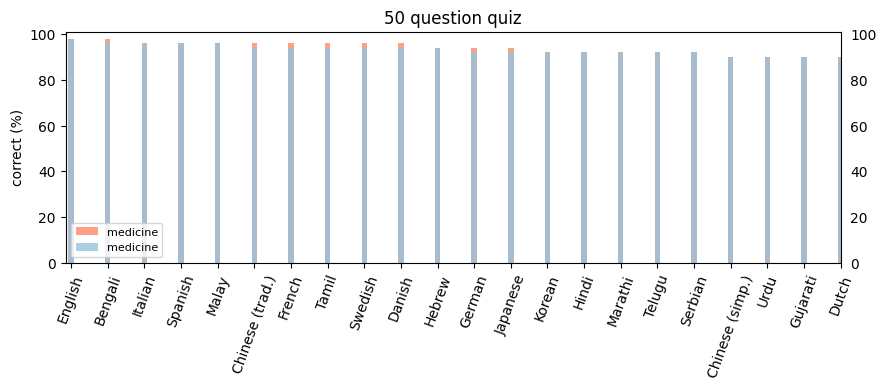

In [78]:
# 20 questions @ temp=0
# Translated questions @ temp=0
# Quiz @ temp=0,1
articles = [articles[0]]
article_labels = [article_labels[0]]
plot_quiz(["20q_temp0/temp0","20q_temp0/temp0_nocontext"], [plt.cm.Reds,plt.cm.Blues], plot_avg=False)
plot_quiz(["20q_temp0/temp1","20q_temp0/temp1_nocontext"], [plt.cm.Reds,plt.cm.Blues], plot_avg=False)
plot_quiz(["50q_temp1/temp0","50q_temp1/temp0_nocontext"], [plt.cm.Reds,plt.cm.Blues], plot_avg=False)
plot_quiz(["50q_temp1/temp1","50q_temp1/temp1_nocontext"], [plt.cm.Reds,plt.cm.Blues], plot_avg=False)

['English', 'Chinese (simp.)', 'Chinese (trad.)', 'German', 'French', 'Korean', 'Bengali', 'Italian', 'Hebrew', 'Japanese', 'Hindi', 'Urdu', 'Tamil', 'Telugu', 'Dutch', 'Swedish', 'Danish', 'Malay', 'Serbian', 'Marathi', 'Gujarati', 'Spanish']
[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 90.0, 90.0, 90.0]
['English', 'Chinese (simp.)', 'Chinese (trad.)', 'Japanese', 'Korean', 'Telugu', 'Italian', 'Spanish', 'German', 'French', 'Hindi', 'Bengali', 'Marathi', 'Tamil', 'Dutch', 'Swedish', 'Danish', 'Hebrew', 'Malay', 'Serbian', 'Urdu', 'Gujarati']
[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 90.0, 90.0]


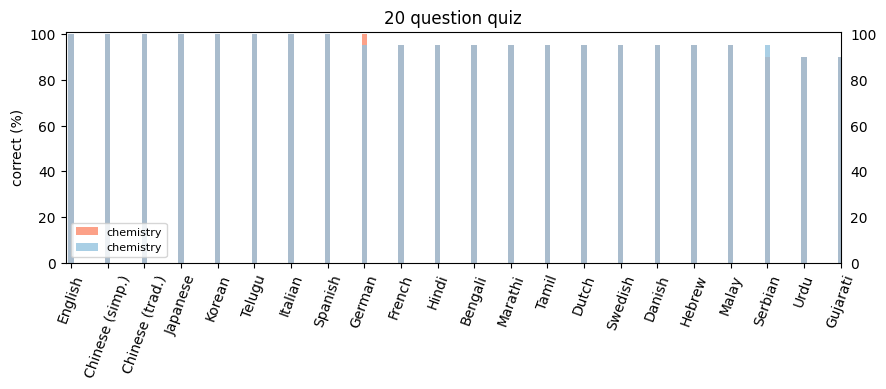

['English', 'Chinese (trad.)', 'German', 'Korean', 'Urdu', 'Tamil', 'Italian', 'Hebrew', 'Serbian', 'Chinese (simp.)', 'Japanese', 'French', 'Bengali', 'Marathi', 'Spanish', 'Dutch', 'Danish', 'Hindi', 'Telugu', 'Gujarati', 'Swedish', 'Malay']
[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 90.0, 90.0, 90.0, 90.0, 90.0]
['Chinese (simp.)', 'Japanese', 'French', 'Korean', 'Marathi', 'Telugu', 'Spanish', 'Malay', 'English', 'Chinese (trad.)', 'German', 'Hindi', 'Bengali', 'Tamil', 'Italian', 'Dutch', 'Swedish', 'Danish', 'Hebrew', 'Urdu', 'Gujarati', 'Serbian']
[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 95.0, 90.0, 90.0, 90.0]


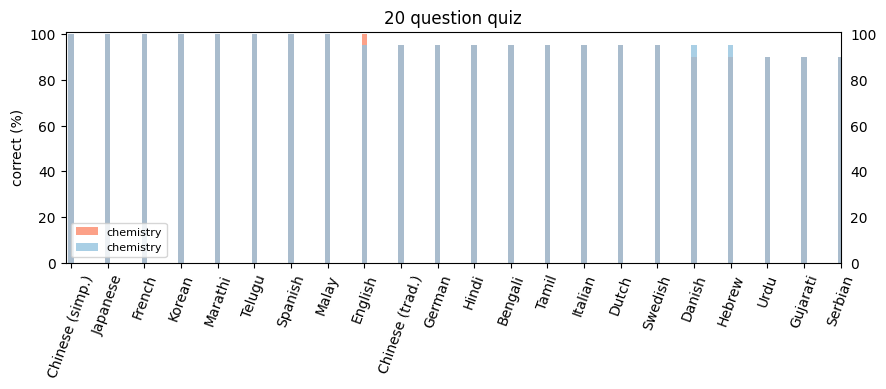

['English', 'Chinese (simp.)', 'German', 'Japanese', 'French', 'Korean', 'Hindi', 'Bengali', 'Italian', 'Spanish', 'Dutch', 'Malay', 'Serbian', 'Chinese (trad.)', 'Urdu', 'Telugu', 'Gujarati', 'Swedish', 'Danish', 'Hebrew', 'Marathi', 'Tamil']
[98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 96.0, 96.0, 96.0, 96.0, 96.0, 96.0, 96.0, 94.0, 94.0]
['English', 'Chinese (simp.)', 'Chinese (trad.)', 'German', 'Japanese', 'French', 'Korean', 'Hindi', 'Bengali', 'Italian', 'Spanish', 'Dutch', 'Swedish', 'Hebrew', 'Malay', 'Serbian', 'Urdu', 'Telugu', 'Gujarati', 'Danish', 'Marathi', 'Tamil']
[98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 96.0, 96.0, 96.0, 96.0, 94.0, 94.0]


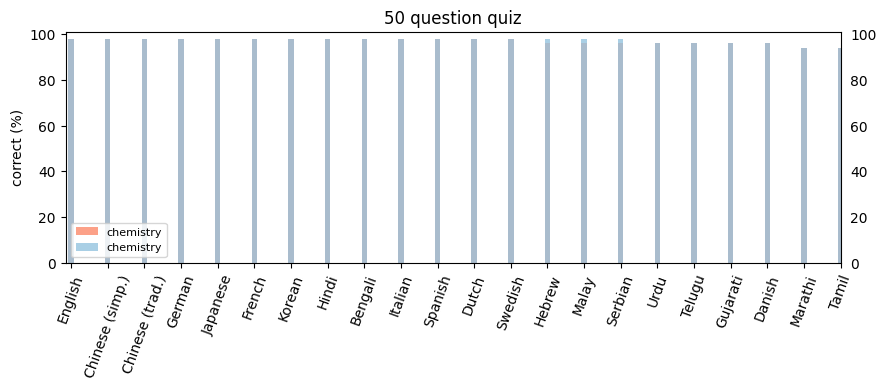

['English', 'Chinese (simp.)', 'German', 'Japanese', 'French', 'Korean', 'Bengali', 'Italian', 'Spanish', 'Dutch', 'Danish', 'Hebrew', 'Serbian', 'Chinese (trad.)', 'Hindi', 'Gujarati', 'Swedish', 'Malay', 'Urdu', 'Marathi', 'Telugu', 'Tamil']
[98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 96.0, 96.0, 96.0, 96.0, 96.0, 94.0, 94.0, 94.0, 90.0]
['Italian', 'English', 'Chinese (simp.)', 'Chinese (trad.)', 'German', 'Japanese', 'French', 'Bengali', 'Spanish', 'Dutch', 'Swedish', 'Hebrew', 'Malay', 'Korean', 'Hindi', 'Urdu', 'Telugu', 'Danish', 'Serbian', 'Marathi', 'Gujarati', 'Tamil']
[100.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 98.0, 96.0, 96.0, 96.0, 96.0, 96.0, 96.0, 94.0, 94.0, 88.0]


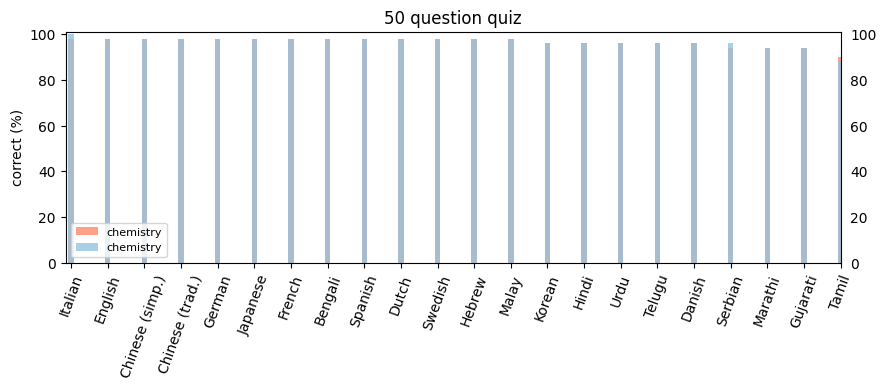

['10X1038_s41467-023-43444-3',
 '10X1038_s41467-018-04608-8',
 '10X1038_s41467-023-42766-6',
 '10X1038_s41467-017-00516-5',
 '10X1038_s41467-019-11343-1']

In [81]:
# 20 questions @ temp=0
# Translated questions @ temp=0
# Quiz @ temp=0,1
articles = reset_articles()
articles = [articles[3]]
article_labels = [article_labels[3]]
plot_quiz(["20q_temp0/temp0","20q_temp0/temp0_nocontext"], [plt.cm.Reds,plt.cm.Blues], plot_avg=False)
plot_quiz(["20q_temp0/temp1","20q_temp0/temp1_nocontext"], [plt.cm.Reds,plt.cm.Blues], plot_avg=False)
plot_quiz(["50q_temp1/temp0","50q_temp1/temp0_nocontext"], [plt.cm.Reds,plt.cm.Blues], plot_avg=False)
plot_quiz(["50q_temp1/temp1","50q_temp1/temp1_nocontext"], [plt.cm.Reds,plt.cm.Blues], plot_avg=False)
reset_articles()

['German', 'Danish', 'English', 'Chinese (trad.)', 'Japanese', 'Bengali', 'Italian', 'Dutch', 'Korean', 'Hebrew', 'Spanish', 'French', 'Swedish', 'Urdu', 'Serbian', 'Hindi', 'Gujarati', 'Malay', 'Chinese (simp.)', 'Marathi', 'Tamil', 'Telugu']
[93.0, 91.0, 90.0, 90.0, 90.0, 90.0, 90.0, 90.0, 89.0, 89.0, 88.0, 87.0, 87.0, 86.0, 86.0, 85.0, 84.0, 84.0, 83.0, 83.0, 81.0, 77.0]


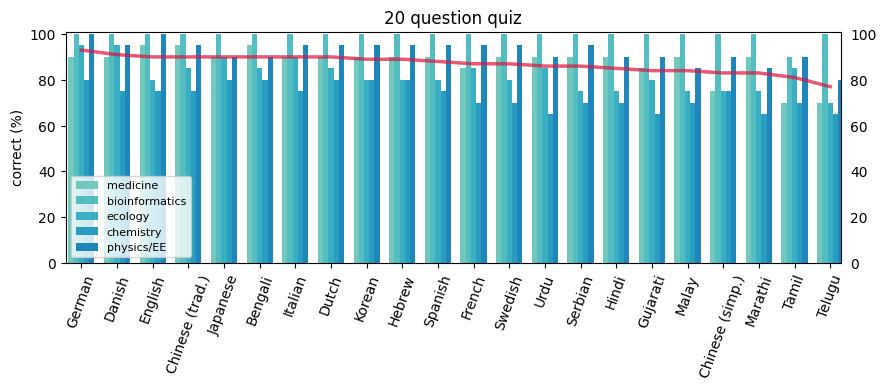

['Spanish', 'Japanese', 'Italian', 'Dutch', 'Serbian', 'Swedish', 'Danish', 'Chinese (trad.)', 'Hebrew', 'English', 'Chinese (simp.)', 'German', 'French', 'Bengali', 'Korean', 'Malay', 'Hindi', 'Gujarati', 'Tamil', 'Urdu', 'Marathi', 'Telugu']
[91.0, 89.0, 89.0, 89.0, 89.0, 88.0, 88.0, 87.0, 87.0, 86.0, 86.0, 86.0, 86.0, 86.0, 85.0, 85.0, 84.0, 83.0, 82.0, 81.0, 81.0, 77.0]


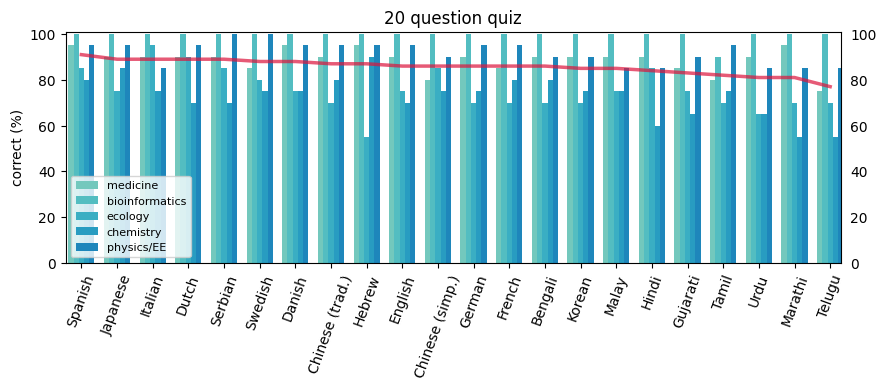

['Chinese (trad.)', 'Gujarati', 'Serbian', 'Hindi', 'Dutch', 'German', 'Italian', 'Chinese (simp.)', 'Japanese', 'French', 'Marathi', 'Swedish', 'Danish', 'English', 'Bengali', 'Spanish', 'Hebrew', 'Malay', 'Korean', 'Telugu', 'Urdu', 'Tamil']
[97.0, 97.0, 96.0, 95.0, 95.0, 94.0, 94.0, 93.0, 93.0, 93.0, 93.0, 93.0, 93.0, 92.0, 92.0, 92.0, 92.0, 92.0, 91.0, 91.0, 90.0, 90.0]


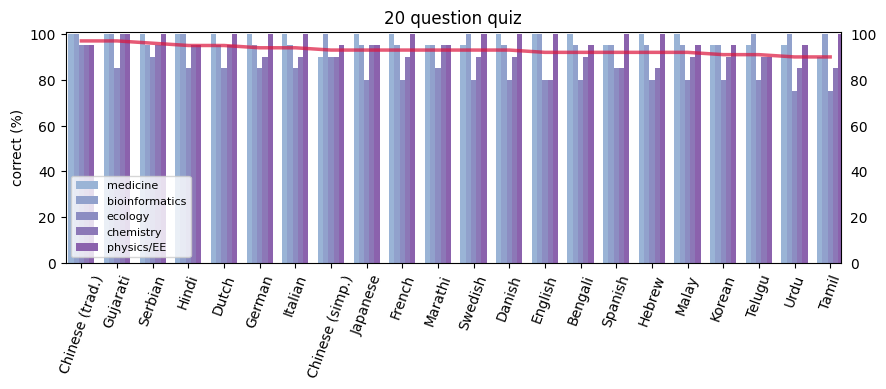

['Chinese (trad.)', 'Japanese', 'English', 'Bengali', 'Italian', 'French', 'Korean', 'Hindi', 'Marathi', 'Malay', 'German', 'Telugu', 'Gujarati', 'Spanish', 'Dutch', 'Hebrew', 'Swedish', 'Urdu', 'Tamil', 'Serbian', 'Danish', 'Chinese (simp.)']
[96.0, 95.0, 94.0, 94.0, 94.0, 93.0, 93.0, 93.0, 93.0, 93.0, 92.0, 92.0, 92.0, 92.0, 92.0, 92.0, 91.0, 90.0, 90.0, 90.0, 89.0, 87.0]


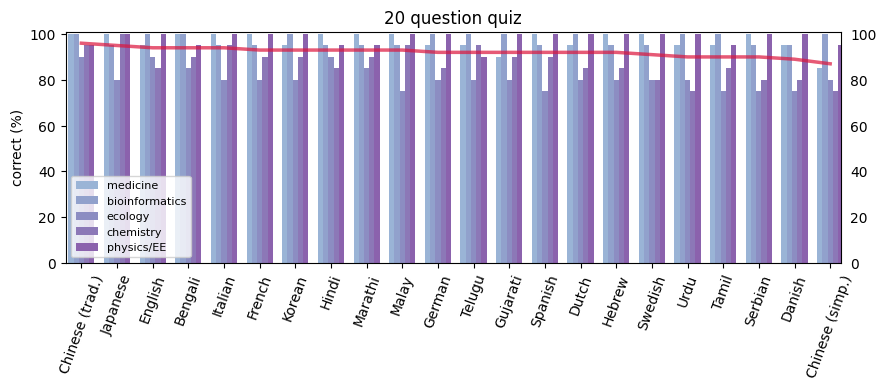

In [83]:
# figures/tables questions only!
# EDIT: QUIZ IS *NOT* ACCESSING FIGURE PICTURES HERE

plot_quiz(["20q_temp0_figs/temp0"], [plt.cm.YlGnBu], plot_avg=True)
plot_quiz(["20q_temp0_figs/temp1"], [plt.cm.YlGnBu], plot_avg=True)
plot_quiz(["20q_temp1_figs/temp0"], [plt.cm.BuPu], plot_avg=True)
plot_quiz(["20q_temp1_figs/temp1"], [plt.cm.BuPu], plot_avg=True)

[0.9090909090909091, 0.045454545454545456, 0.8181818181818182, 1.0, 0.6818181818181818]


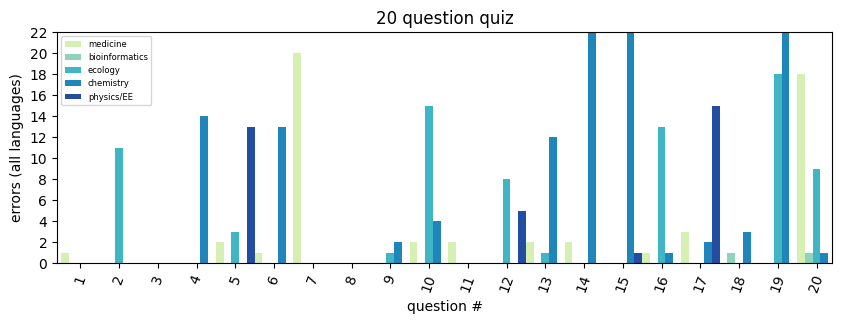

[0.9545454545454546, 0.045454545454545456, 0.7272727272727273, 1.0, 0.6363636363636364]


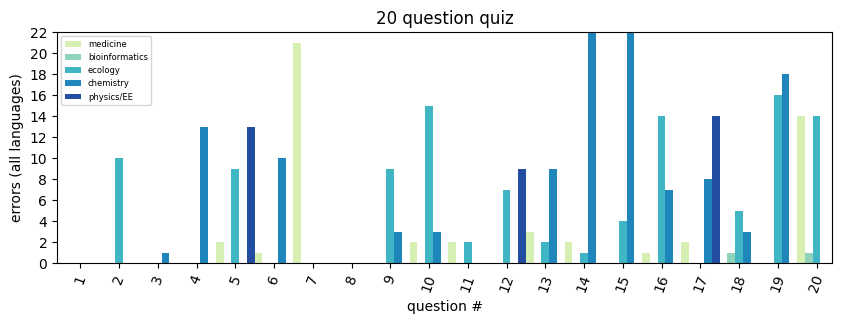

[0.13636363636363635, 0.5909090909090909, 1.0, 0.8181818181818182, 0.3181818181818182]


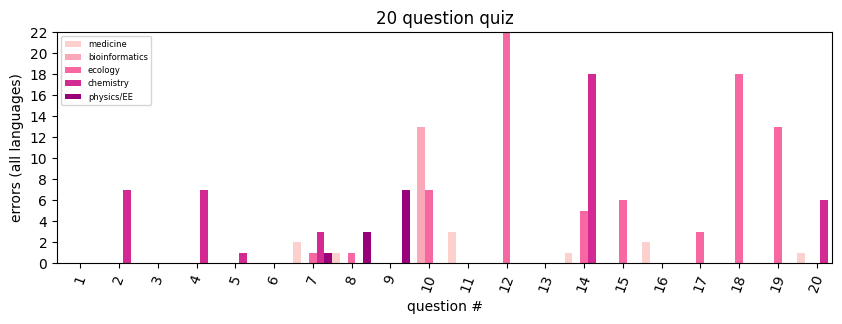

[0.22727272727272727, 0.5, 1.0, 0.7272727272727273, 0.18181818181818182]


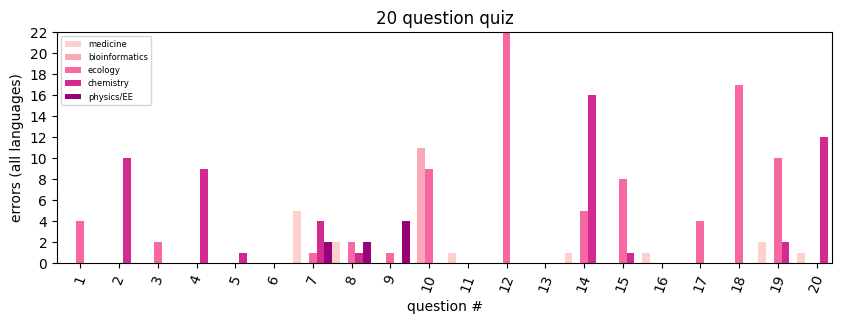

In [84]:
plot_q_stats("20q_temp0_figs/temp0", plt.cm.YlGnBu)
plot_q_stats("20q_temp0_figs/temp1", plt.cm.YlGnBu)
plot_q_stats("20q_temp1_figs/temp0", plt.cm.RdPu)
plot_q_stats("20q_temp1_figs/temp1", plt.cm.RdPu)

['English', 'German', 'Japanese', 'French', 'Dutch', 'Spanish', 'Danish', 'Korean', 'Italian', 'Swedish', 'Chinese (trad.)', 'Bengali', 'Urdu', 'Hebrew', 'Malay', 'Serbian', 'Chinese (simp.)', 'Hindi', 'Marathi', 'Gujarati', 'Tamil', 'Telugu']
[93.0, 92.0, 92.0, 92.0, 92.0, 91.0, 91.0, 90.0, 90.0, 90.0, 89.0, 89.0, 89.0, 88.0, 88.0, 88.0, 87.0, 87.0, 87.0, 86.0, 83.0, 81.0]


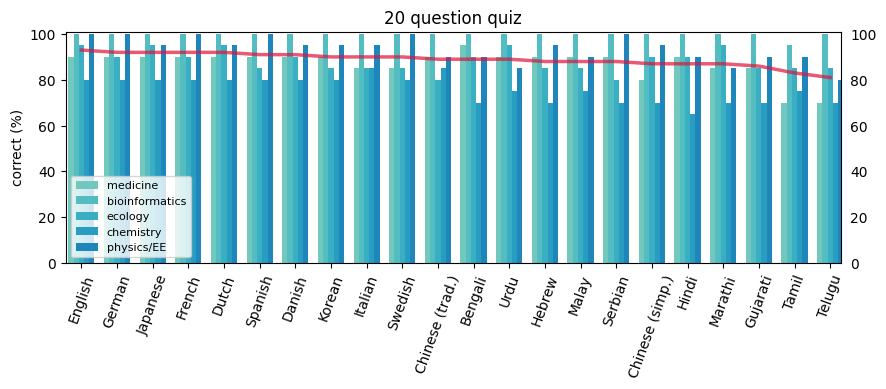

['Dutch', 'English', 'Danish', 'French', 'Korean', 'Chinese (trad.)', 'Swedish', 'Serbian', 'German', 'Japanese', 'Bengali', 'Spanish', 'Hebrew', 'Italian', 'Malay', 'Urdu', 'Chinese (simp.)', 'Gujarati', 'Marathi', 'Hindi', 'Telugu', 'Tamil']
[93.0, 92.0, 91.0, 90.0, 90.0, 89.0, 89.0, 89.0, 88.0, 88.0, 88.0, 88.0, 87.0, 85.0, 85.0, 84.0, 83.0, 83.0, 82.0, 81.0, 79.0, 78.0]


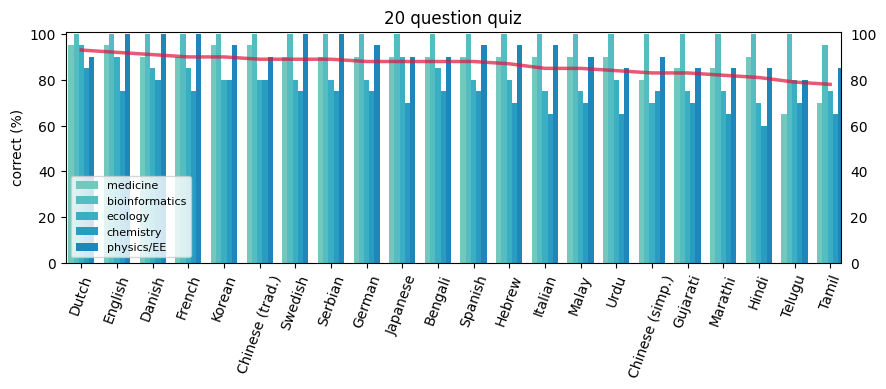

['Hindi', 'Chinese (trad.)', 'Marathi', 'English', 'Gujarati', 'Chinese (simp.)', 'Japanese', 'Serbian', 'German', 'French', 'Bengali', 'Dutch', 'Danish', 'Malay', 'Korean', 'Urdu', 'Italian', 'Hebrew', 'Spanish', 'Swedish', 'Telugu', 'Tamil']
[97.0, 96.0, 96.0, 95.0, 95.0, 94.0, 94.0, 94.0, 93.0, 93.0, 93.0, 93.0, 93.0, 93.0, 92.0, 92.0, 92.0, 92.0, 91.0, 91.0, 90.0, 89.0]


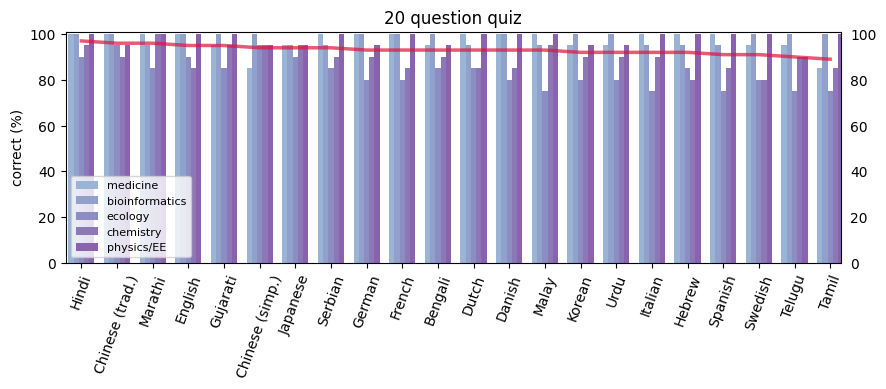

In [107]:
# figures/tables questions only!
# EDIT: QUIZ *IS* ACCESSING FIGURE PICTURES HERE

plot_quiz(["20q_temp0_figs/temp0_a"], [plt.cm.YlGnBu], plot_avg=True)
plot_quiz(["20q_temp0_figs/temp1_a"], [plt.cm.YlGnBu], plot_avg=True)
plot_quiz(["20q_temp1_figs/temp0_a"], [plt.cm.BuPu], plot_avg=True)
# plot_quiz(["20q_temp1_figs/temp1_a"], [plt.cm.BuPu], plot_avg=True)

['Japanese', 'French', 'Dutch', 'Swedish', 'Serbian', 'Portuguese', 'Russian', 'Arabic', 'English', 'Chinese (simp.)', 'Chinese (trad.)', 'Urdu', 'Italian', 'Spanish', 'Danish', 'Hebrew', 'Malay', 'Swahili', 'German', 'Korean', 'Hindi', 'Bengali', 'Marathi', 'Telugu', 'Farsi', 'Gujarati', 'Turkish', 'Tamil']
[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 99.16666666666667, 99.16666666666667, 99.16666666666667, 99.16666666666667, 99.16666666666667, 99.16666666666667, 99.16666666666667, 99.16666666666667, 99.16666666666667, 99.16666666666667, 98.33333333333333, 98.33333333333333, 98.33333333333333, 98.33333333333333, 98.33333333333333, 98.33333333333333, 98.33333333333333, 97.5, 96.66666666666667, 95.83333333333333]


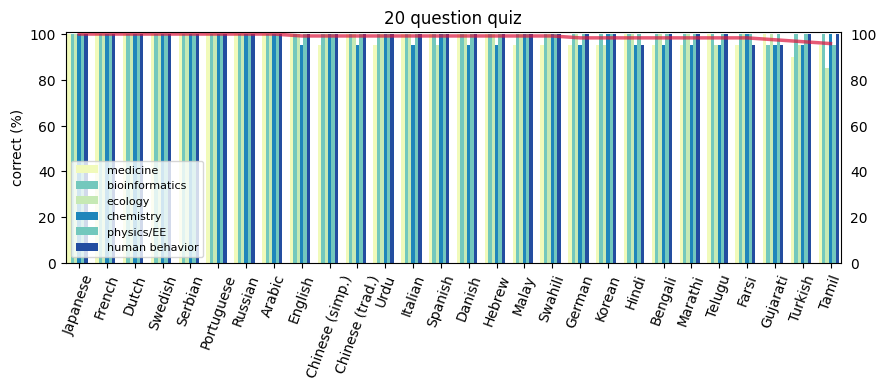

['Italian', 'Swedish', 'Farsi', 'English', 'French', 'Dutch', 'Malay', 'Portuguese', 'Arabic', 'Chinese (trad.)', 'Japanese', 'Korean', 'German', 'Urdu', 'Marathi', 'Danish', 'Chinese (simp.)', 'Bengali', 'Hebrew', 'Serbian', 'Turkish', 'Russian', 'Hindi', 'Telugu', 'Spanish', 'Swahili', 'Gujarati', 'Tamil']
[97.66666666666667, 97.66666666666667, 97.66666666666667, 97.33333333333333, 97.33333333333333, 97.33333333333333, 97.33333333333333, 97.33333333333333, 97.33333333333333, 97.0, 97.0, 97.0, 96.66666666666667, 96.66666666666667, 96.66666666666667, 96.66666666666667, 96.33333333333333, 96.33333333333333, 96.33333333333333, 96.33333333333333, 95.66666666666667, 95.66666666666667, 95.33333333333333, 95.33333333333333, 95.0, 95.0, 94.66666666666667, 94.33333333333333]


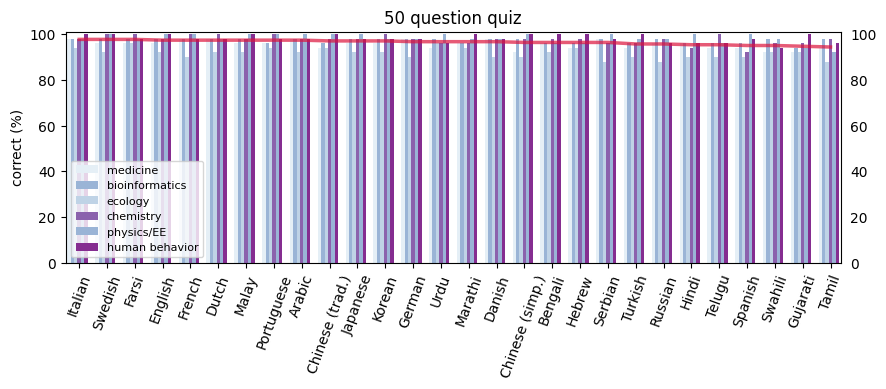

In [117]:
# GENERAL q&a including MORE LANGUAGES (arabic, farsi, swahili, turkish, russian, portuguese)
# also, using the lang_full.txt files which are better formatted!

cw = [0.1,0.4,0.25,0.65,0.4,0.8]
plot_quiz(["20q_temp0_gen/temp1"], [plt.cm.YlGnBu], colorway=[cw], barwidth=0.0045, plot_avg=True)
# plot_quiz(["20q_temp0_figs/temp1_a"], [plt.cm.YlGnBu], plot_avg=True)
# plot_quiz(["20q_temp1_figs/temp0_a"], [plt.cm.BuPu], plot_avg=True)
plot_quiz(["50q_temp1_gen/temp1"], [plt.cm.BuPu], colorway=[cw], barwidth=0.0045, plot_avg=True)

[0.5488135  0.71518937 0.60276338 0.54488318 0.4236548  0.64589411]
['Italian', 'Swedish', 'Farsi', 'English', 'French', 'Dutch', 'Malay', 'Portuguese', 'Arabic', 'Chinese (trad.)', 'Japanese', 'Korean', 'German', 'Urdu', 'Marathi', 'Danish', 'Chinese (simp.)', 'Bengali', 'Hebrew', 'Serbian', 'Turkish', 'Russian', 'Hindi', 'Telugu', 'Spanish', 'Swahili', 'Gujarati', 'Tamil']
[97.66666666666667, 97.66666666666667, 97.66666666666667, 97.33333333333333, 97.33333333333333, 97.33333333333333, 97.33333333333333, 97.33333333333333, 97.33333333333333, 97.0, 97.0, 97.0, 96.66666666666667, 96.66666666666667, 96.66666666666667, 96.66666666666667, 96.33333333333333, 96.33333333333333, 96.33333333333333, 96.33333333333333, 95.66666666666667, 95.66666666666667, 95.33333333333333, 95.33333333333333, 95.0, 95.0, 94.66666666666667, 94.33333333333333]


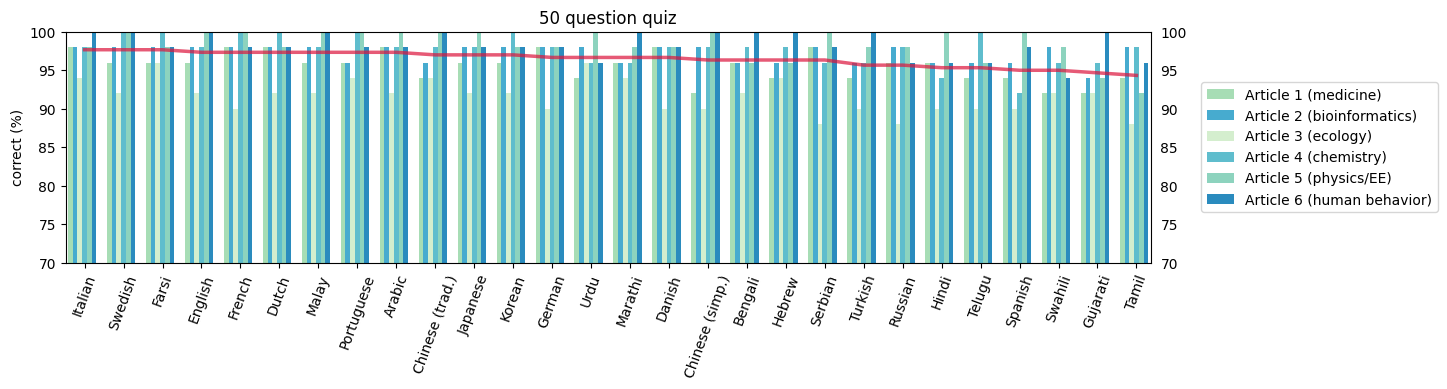

In [284]:
# SAME DATA AS ABOVE BUT REPLOTTED FOR CLARITY

np.random.seed(0)
cw = np.random.rand(len(articles))
print(cw)
cw = np.array([0.175,0.45,0.00,0.375,0.25,0.55])+0.2
# cw = np.linspace(0,1,len(articles))

plot_quiz(["50q_temp1_gen/temp1"],
          [plt.cm.GnBu], colorway=[cw],
          barwidth=0.0045, size=(14,3), ylim=[70,100],
          plot_avg=True, legend=True, save="../Figures/test.png")